In [226]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet #pt
from scipy.special import expit as logistic
import arviz as az
from scipy import stats

import statsmodels.api as sm
import scipy.stats as stats

import matplotlib.patheffects as path_effects
from itertools import product
import datetime as dt
from tqdm import tqdm
import seaborn as sns
sns.set_style("whitegrid")

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

In [227]:
president_polls_url = 'https://projects.fivethirtyeight.com/polls/data/president_polls.csv'
df = pd.read_csv(president_polls_url)
df.to_csv("../Data/raw/president_polls.csv")

In [228]:
df = pd.read_csv("../Data/raw/president_polls.csv")

df_state = pd.read_csv("../Data/clean/state_code.csv")

df.loc[df['party'].isin(['REP', 'DEM']) == False, 'party'] = 'OTH'
#df.loc[(df['party'].isin(['REP', 'DEM']) == False) & (df['answer'] != 'Kennedy'), 'party'] = 'OTH'
df = df[df['party'] != 'OTH']

In [229]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_93510/3015971515.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_date'] = pd.to_datetime(df['start_date'])
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_93510/3015971515.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end_date'] = pd.to_datetime(df['end_date'])


In [230]:
df['median_date'] = df['start_date'] + (df['end_date'] - df['start_date']) / 2
df.median_date = df.median_date.dt.round('D')

In [231]:
df['date'] = df.median_date
#df['date'] = df.end_date
df = df[df['date'] >= '2024-01-01'] #Only polls during election year
df['week'] = (df['date'] - pd.Timestamp('2024-11-05')).dt.days // 7
df['day'] = (df['date'] - pd.Timestamp('2024-11-05')).dt.days

df = df.merge(df_state[['state','state_code']], how='left')
df.fillna({'state_code':"US"}, inplace=True)
df['state'] = df['state_code']

df = df.set_index('date')
df = df[["poll_id", "question_id", "pollster_id", "pollster", "numeric_grade", "methodology", "state", 'population', 'sample_size', 'cycle', 'election_date', 'week', 'day', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct']]

In [232]:
df['year'] = df.index.year
df['month'] = df.index.month

df = df.dropna()

In [233]:
df2 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['answer']) == {'Trump', 'Harris'})

df_count = df2.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df2.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', "numeric_grade", 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way = df_polls.merge(df_count)
df_2way = df_2way.rename(columns={'REP':'GOP'})
df_2way['type'] = '2way'
df_2way = df_2way[df_2way['date'] >= '2024-07-21'] 

df_2way['sample_size'] = round(df_2way['sample_size'] * (df_2way['DEM'] + df_2way['GOP'])/100)
df_2way[['DEM', 'GOP']] = df_2way[['DEM', 'GOP']].div(100)

In [234]:
df3 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['answer']) == {'Trump', 'Biden'})

df_count = df3.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df3.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', "numeric_grade", 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way_jb = df_polls.merge(df_count)
df_2way_jb = df_2way_jb.rename(columns={'REP':'GOP'})
df_2way_jb['type'] = '2way'
df_2way_jb = df_2way_jb[df_2way_jb['date'] < '2024-07-21'] 

#df_2way_jb['sample_size'] = round(df_2way_jb['sample_size'] * (df_2way_jb['DEM'] + df_2way_jb['GOP'])/100)
df_2way_jb[['DEM', 'GOP']] = df_2way_jb[['DEM', 'GOP']].div(100)

In [235]:
df = pd.concat([df_2way, df_2way_jb])

df = df.dropna()
df['obs_id'] = range(len(df))
df['OTHER'] = 1 - (df['DEM'] + df['GOP'])

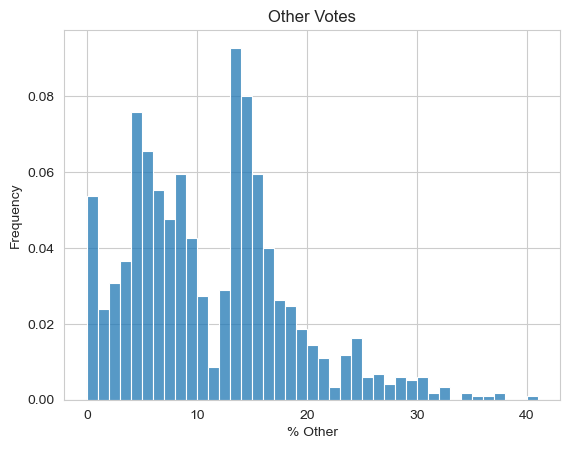

In [236]:
bin_width = 1
max_value = (100 * df.query("state == 'US'")['OTHER']).max()
bins = int(max_value / bin_width)

sns.histplot(100 * df.query("state == 'US'")['OTHER'], bins=bins, stat="probability")
plt.xlabel('% Other')
plt.ylabel('Frequency')
plt.title('Other Votes')

plt.savefig('other_performance.png')

In [239]:
#df = df.query("OTHER > 0")

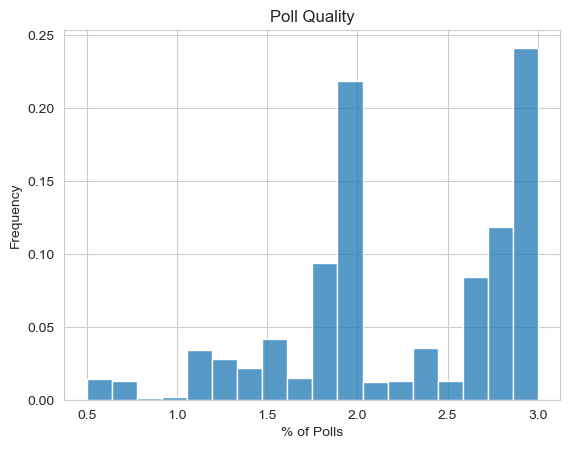

In [240]:
sns.histplot(df['numeric_grade'], stat="probability")
plt.xlabel('% of Polls')
plt.ylabel('Frequency')
plt.title('Poll Quality')

plt.savefig('other_performance.png')

In [241]:
df = df.query("numeric_grade >= 2")

In [242]:
df.state.value_counts()

state
US      502
PA      138
MI      109
WI      106
NC      102
AZ       91
GA       88
NV       64
TX       35
VA       33
FL       28
NH       25
CA       24
OH       19
NY       18
MN       18
MA       14
MD       12
MT       11
NE-2     10
ME        8
IA        7
NE        7
UT        7
ME-1      6
ME-2      6
RI        5
NM        5
WA        5
NJ        5
MO        5
SD        4
SC        4
VT        3
AK        3
CO        2
IN        2
OK        2
NE-1      1
NE-3      1
CT        1
WV        1
TN        1
Name: count, dtype: int64

In [243]:
df = df[df['state'].isin(df['state'].value_counts()[df['state'].value_counts() >= 10].index)]

Two way Biden vs Trump, Biden loses by 0.3%. Kamala loses by 4.8%. This is because Kamala's polling occured more after the race moved in Trump's favor.

In [244]:
df[['DEM', 'GOP']].describe()

,DEM,GOP
count,1447.000000,1447.000000
mean,0.456013,0.452766
std,0.050999,0.046557
min,0.270000,0.220000
25%,0.420000,0.430000
50%,0.470000,0.460000
75%,0.490000,0.484000
max,0.653000,0.590000


In [245]:
df

,poll_id,question_id,pollster_id,pollster,numeric_grade,methodology,state,population,sample_size,cycle,...,date,year,month,day,week,DEM,GOP,type,obs_id,OTHER
0,89320,216171,1478,Research Co.,2.4,Online Panel,CA,lv,432.0,2024,...,2024-11-03,2024,11,-2,-1,0.64,0.32,2way,0,0.04
1,89321,216172,1478,Research Co.,2.4,Online Panel,FL,lv,428.0,2024,...,2024-11-03,2024,11,-2,-1,0.44,0.51,2way,1,0.05
2,89322,216173,1478,Research Co.,2.4,Online Panel,MI,lv,432.0,2024,...,2024-11-03,2024,11,-2,-1,0.49,0.47,2way,2,0.04
3,89323,216174,1478,Research Co.,2.4,Online Panel,MN,lv,428.0,2024,...,2024-11-03,2024,11,-2,-1,0.51,0.44,2way,3,0.05
6,89326,216177,1478,Research Co.,2.4,Online Panel,NY,lv,441.0,2024,...,2024-11-03,2024,11,-2,-1,0.57,0.41,2way,6,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,85587,190226,1800,Noble Predictive Insights,2.4,Online Panel/Text-to-Web,US,lv,2364.0,2024,...,2024-01-03,2024,1,-307,-44,0.41,0.45,2way,3003,0.14
1236,85587,190227,1800,Noble Predictive Insights,2.4,Online Panel/Text-to-Web,US,rv,2573.0,2024,...,2024-01-03,2024,1,-307,-44,0.40,0.44,2way,3004,0.16
1237,85587,190228,1800,Noble Predictive Insights,2.4,Online Panel/Text-to-Web,US,lv,2364.0,2024,...,2024-01-03,2024,1,-307,-44,0.36,0.41,2way,3005,0.23
1238,85587,190229,1800,Noble Predictive Insights,2.4,Online Panel/Text-to-Web,US,rv,2573.0,2024,...,2024-01-03,2024,1,-307,-44,0.35,0.41,2way,3006,0.24


In [246]:
df.query("pollster == 'Siena/NYT'")[['pollster','state', 'sample_size', 'date', 'DEM', 'GOP', 'OTHER']]

,pollster,state,sample_size,date,DEM,GOP,OTHER
61,Siena/NYT,MI,908.0,2024-10-31,0.44,0.47,0.09
62,Siena/NYT,MI,858.0,2024-10-31,0.42,0.44,0.14
63,Siena/NYT,MI,938.0,2024-10-31,0.47,0.47,0.06
64,Siena/NYT,MI,898.0,2024-10-31,0.45,0.45,0.10
65,Siena/NYT,PA,1451.0,2024-10-31,0.47,0.48,0.05
...,...,...,...,...,...,...,...
695,Siena/NYT,US,1059.0,2024-04-09,0.40,0.42,0.18
696,Siena/NYT,US,1059.0,2024-04-09,0.46,0.47,0.07
697,Siena/NYT,US,1059.0,2024-04-09,0.42,0.43,0.15
954,Siena/NYT,US,980.0,2024-02-27,0.43,0.48,0.09


In [247]:
df.query("(pollster == 'Siena/NYT') and (date >= '2024-10-01')").groupby("state")[['DEM', 'GOP', 'OTHER']].mean()

,DEM,GOP,OTHER
state,,,
AZ,0.44375,0.491250,0.065000
FL,0.40500,0.537500,0.057500
GA,0.46000,0.455000,0.085000
MI,0.44500,0.457500,0.097500
MT,0.39000,0.565000,0.045000
NC,0.47750,0.445000,0.077500
NE-2,0.53500,0.415000,0.050000
NV,0.48000,0.455000,0.065000
PA,0.48250,0.467500,0.050000


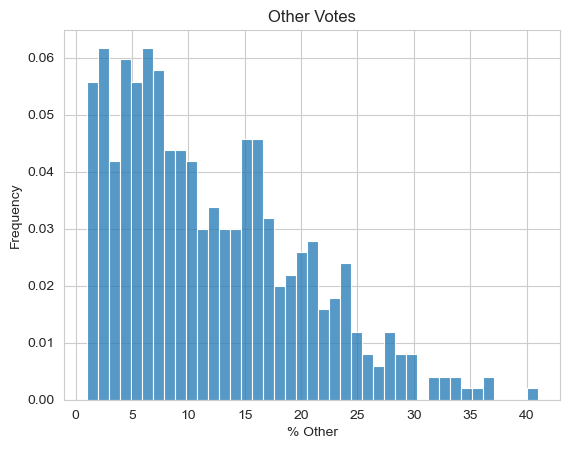

In [248]:
bin_width = 1
max_value = (100 * df.query("state == 'US'")['OTHER']).max()
bins = int(max_value / bin_width)

sns.histplot(100 * df.query("state == 'US'")['OTHER'], bins=bins, stat="probability")
plt.xlabel('% Other')
plt.ylabel('Frequency')
plt.title('Other Votes')

plt.savefig('other_performance.png')

In [249]:
df[['pollster','state', 'sample_size', 'date', 'DEM', 'GOP', 'OTHER']].head(20)

,pollster,state,sample_size,date,DEM,GOP,OTHER
0,Research Co.,CA,432.0,2024-11-03,0.640,0.320,0.040
1,Research Co.,FL,428.0,2024-11-03,0.440,0.510,0.050
2,Research Co.,MI,432.0,2024-11-03,0.490,0.470,0.040
3,Research Co.,MN,428.0,2024-11-03,0.510,0.440,0.050
6,Research Co.,NY,441.0,2024-11-03,0.570,0.410,0.020
7,Research Co.,PA,428.0,2024-11-03,0.480,0.470,0.050
8,Research Co.,VA,432.0,2024-11-03,0.510,0.450,0.040
10,Research Co.,WI,428.0,2024-11-03,0.490,0.460,0.050
12,Research Co.,US,943.0,2024-11-03,0.480,0.460,0.060
27,Leger,US,867.0,2024-11-01,0.494,0.485,0.021


In [250]:
POLLSTERS = df['pollster'].sort_values().unique()
POLLSTERS_top = df.groupby('pollster').size().sort_values(ascending=False).head(20).index.values

METHODS = df['methodology'].sort_values().unique()
METHODS_top = df.groupby('methodology').size().sort_values(ascending=False).head(10).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(20).index.values

POPULATIONS = df['population'].sort_values().unique()
POPULATIONS_top = df.groupby('population').size().sort_values(ascending=False).head(10).index.values

There have been polls since Spring 2019, and increased exponentially through election day.

In [251]:
# Create the cross-tabulation
cross_tab = pd.crosstab(df['pollster'], df['methodology'], margins=True)

# Extract 'All' row and 'All' column
all_row = cross_tab.loc['All']
all_col = cross_tab['All']

# Sort rows by 'All' column values (excluding the 'All' row)
sorted_rows = all_col.index[all_col.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_rows)

# Sort columns by 'All' row values (excluding the 'All' column)
sorted_columns = all_row.index[all_row.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_columns, axis=1)

cross_tab.iloc[:11, :11]

methodology,All,Online Panel,Live Phone,Probability Panel,Live Phone/Text-to-Web,IVR/Online Panel/Text-to-Web,Online Ad,Online Panel/Text-to-Web,Live Phone/Online Panel/Text-to-Web,IVR/Online Panel/Email,Live Phone/Text-to-Web/Email/Mail-to-Web
pollster,,,,,,,,,,,
All,1447,388,301,164,153,91,82,51,51,27,14
Siena/NYT,178,0,178,0,0,0,0,0,0,0,0
YouGov,169,168,0,0,0,0,0,1,0,0,0
Emerson,156,0,0,0,0,87,0,22,0,27,0
Ipsos,106,0,0,106,0,0,0,0,0,0,0
Beacon/Shaw,88,0,4,0,84,0,0,0,0,0,0
AtlasIntel,82,0,0,0,0,0,82,0,0,0,0
Marist,64,2,0,0,0,0,0,2,46,0,0
Quinnipiac,60,0,60,0,0,0,0,0,0,0,0


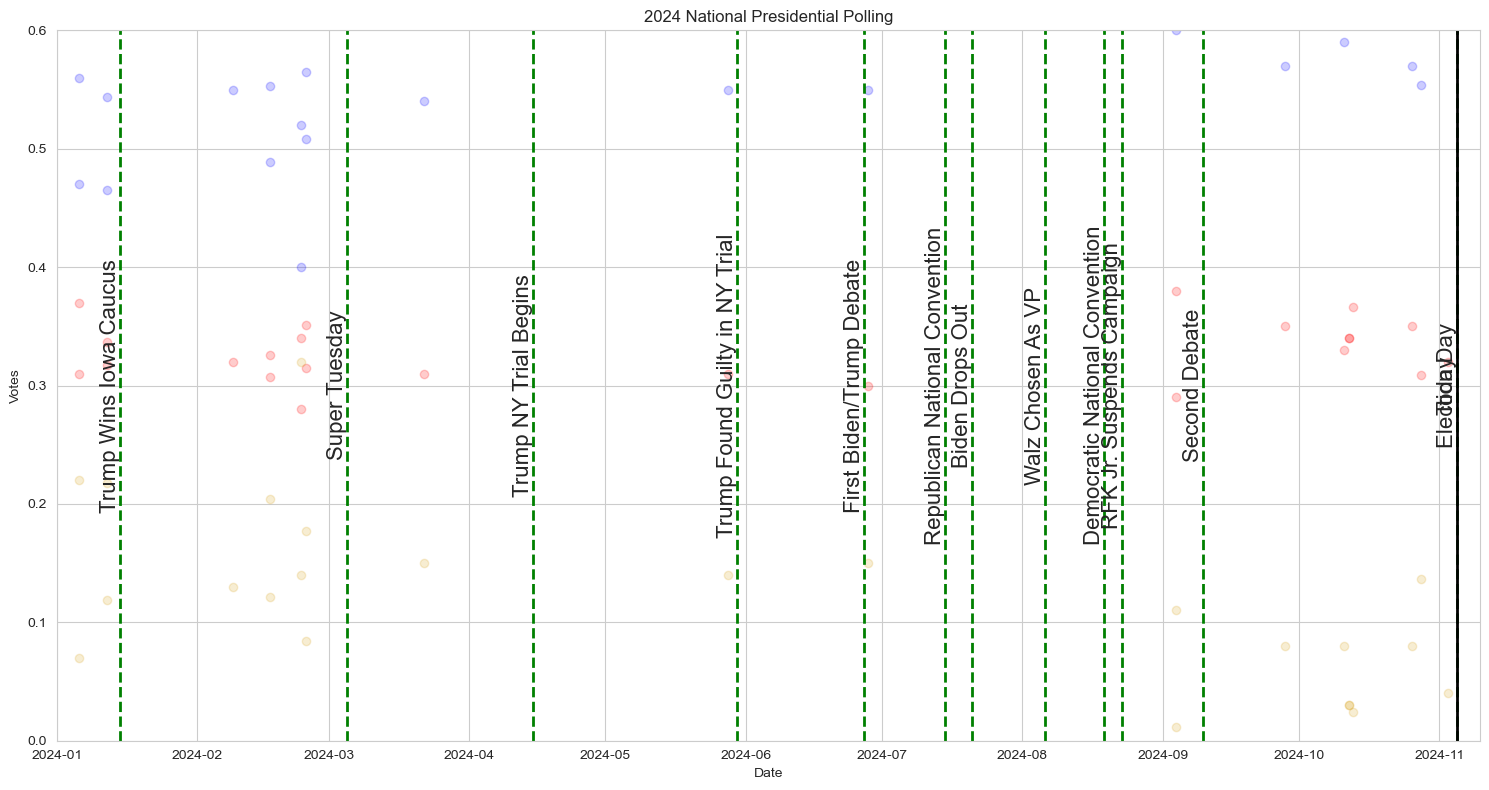

In [252]:
dem_votes = df.query("state == 'CA'")["DEM"].values
gop_votes = df.query("state == 'CA'")["GOP"].values
oth_votes = df.query("state == 'CA'")["OTHER"].values

dates = df.query("state == 'CA'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.2, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.2, color='red', label="Trump")
ax.plot(dates, oth_votes, "o", alpha=0.2, color='goldenrod', label="Other")

# Set limits and labels
ax.set_ylim(0, 0.6)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 10))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2024 National Presidential Polling')

events = [
            (dt.datetime(2024, 1, 15), 'Trump Wins Iowa Caucus'),
            (dt.datetime(2024, 3, 5),  'Super Tuesday'),
            (dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            (dt.datetime(2024, 5, 30), 'Trump Found Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Biden/Trump Debate'),
            (dt.datetime(2024, 7, 15), 'Republican National Convention'),
            (dt.datetime(2024, 7, 21), 'Biden Drops Out'),
            (dt.datetime(2024, 8, 6),  'Walz Chosen As VP'),
            (dt.datetime(2024, 8, 19), 'Democratic National Convention'),
            (dt.datetime(2024, 8, 23), 'RFK Jr. Suspends Campaign'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.3, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)

ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.3, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)

plt.tight_layout()
plt.show()

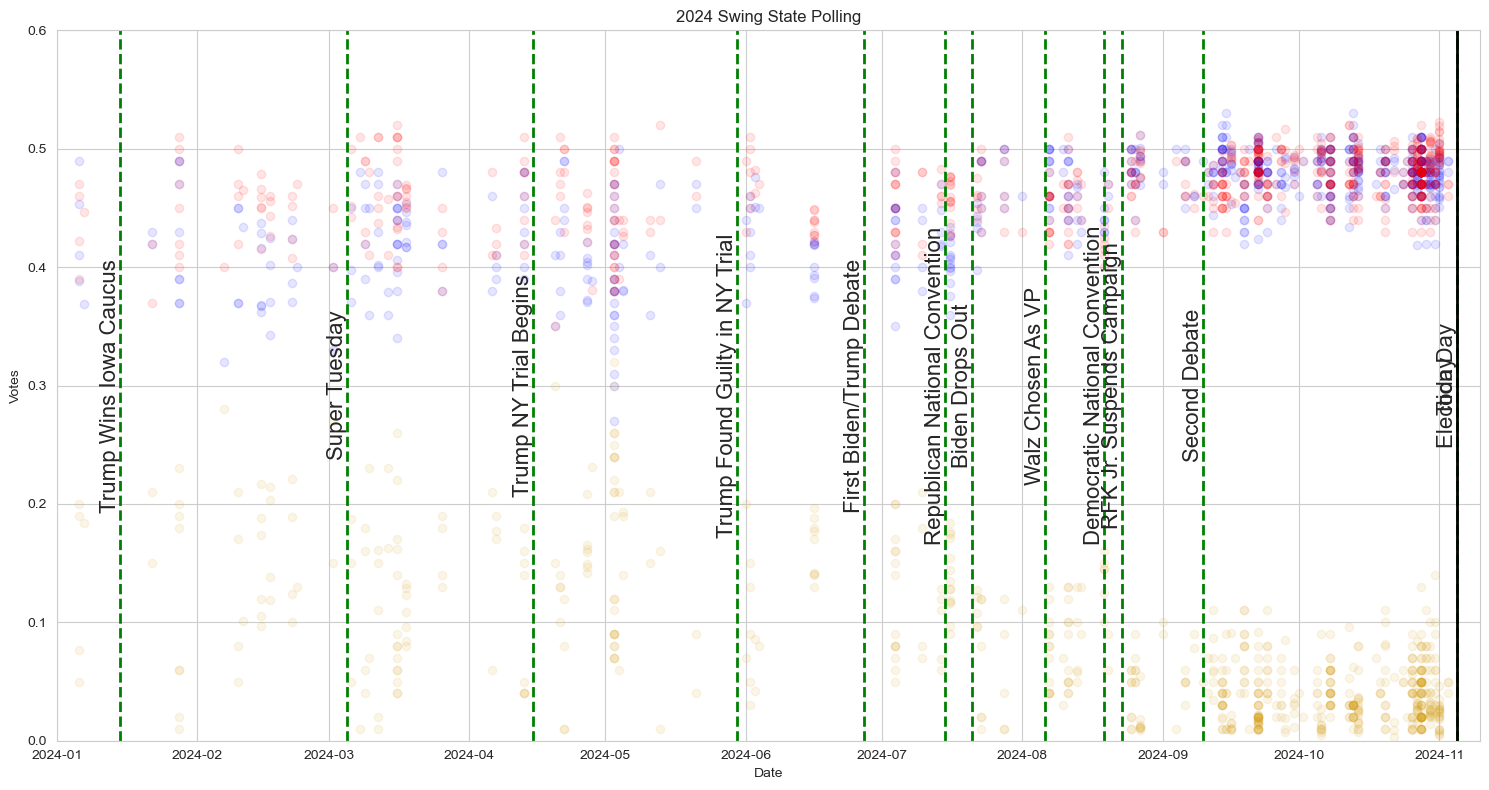

In [253]:
swing_states = ['PA','NC','MI','WI','GA','AZ','NV']
#swing_states = ['MD','MA','CA','WA','NY','CO']
#swing_states = ['TX','OH','SC','NE','MT','UT']

dem_votes = df.query(f"state in {swing_states}")["DEM"].values
gop_votes = df.query(f"state in {swing_states}")["GOP"].values
oth_votes = df.query(f"state in {swing_states}")["OTHER"].values

dates = df.query(f"state in {swing_states}").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=.1, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=.1, color='red', label="Trump")
ax.plot(dates, oth_votes, "o", alpha=.1, color='goldenrod', label="Other")

# Set limits and labels
ax.set_ylim(0, 0.6)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 10))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2024 Swing State Polling')

events = [
            (dt.datetime(2024, 1, 15), 'Trump Wins Iowa Caucus'),
            (dt.datetime(2024, 3, 5),  'Super Tuesday'),
            (dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            (dt.datetime(2024, 5, 30), 'Trump Found Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Biden/Trump Debate'),
            (dt.datetime(2024, 7, 15), 'Republican National Convention'),
            (dt.datetime(2024, 7, 21), 'Biden Drops Out'),
            (dt.datetime(2024, 8, 6),  'Walz Chosen As VP'),
            (dt.datetime(2024, 8, 19), 'Democratic National Convention'),
            (dt.datetime(2024, 8, 23), 'RFK Jr. Suspends Campaign'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.3, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)

ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.3, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, '30-Day Rolling National Polling Standard Deviation')

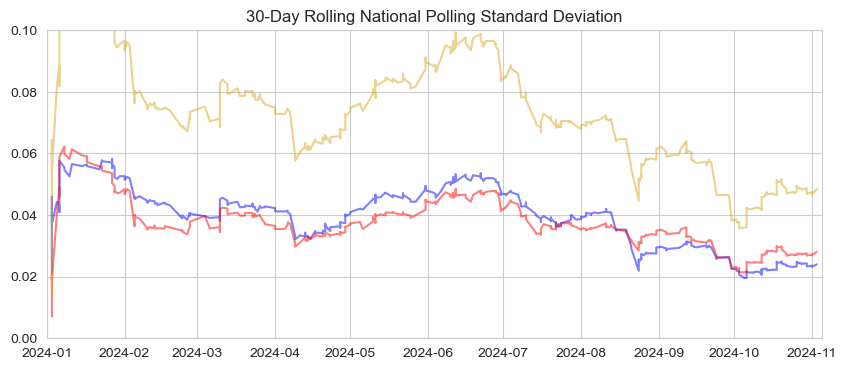

In [254]:
rolling_mean = (
    df.query("state == 'US'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='30D')
    .std()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .1)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_title("30-Day Rolling National Polling Standard Deviation")

Text(0.5, 1.0, '7-Day Rolling Swing State Polling Mean')

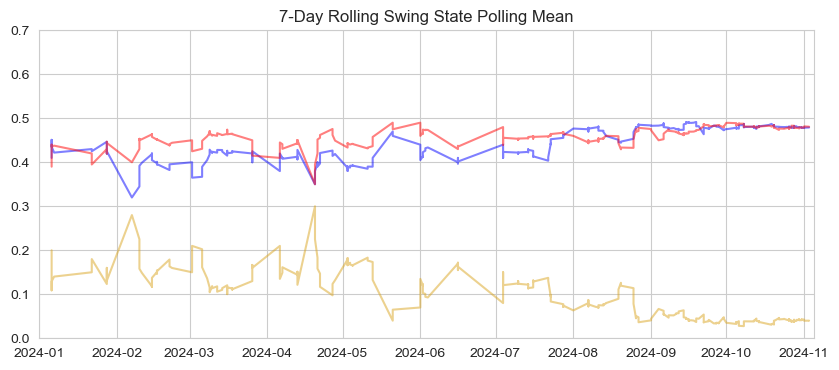

In [255]:
rolling_mean = (
    df.query(f"state in {swing_states}")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)

ax.set_ylim(0, .7)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_title("7-Day Rolling Swing State Polling Mean")

Text(0.5, 1.0, '7-Day Rolling National Polling Mean')

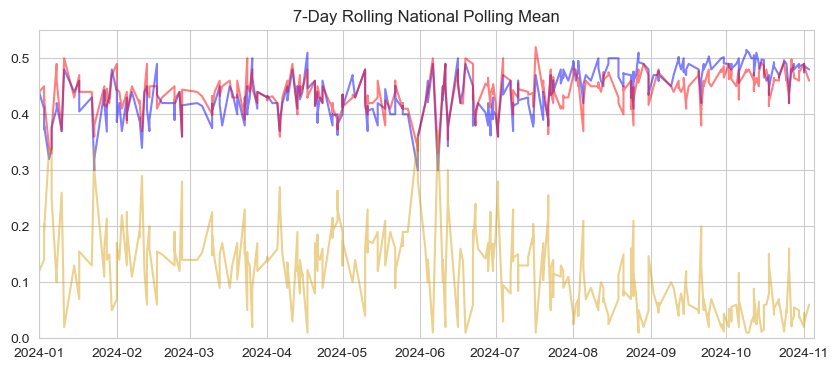

In [256]:
rolling_mean = (
    df.query("state == 'US'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='1D')
    .mean()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .55)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_title("7-Day Rolling National Polling Mean")

Text(0.5, 1.0, '7-Day Rolling National Polling Standard Deviation')

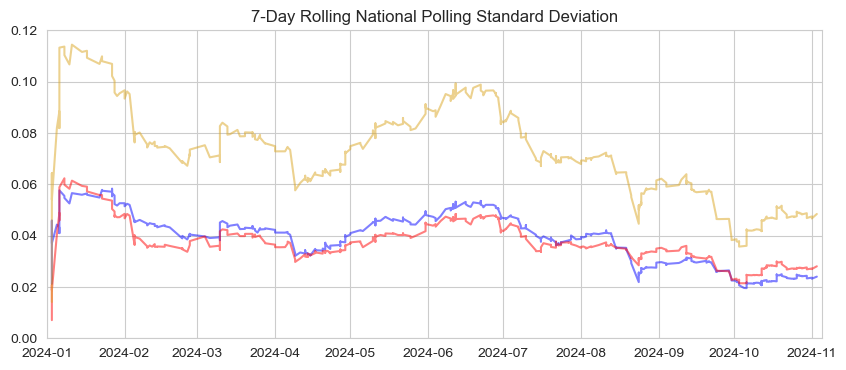

In [257]:
rolling_mean = (
    df.query("state == 'US'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='30D')
    .std()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .12)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_title("7-Day Rolling National Polling Standard Deviation")

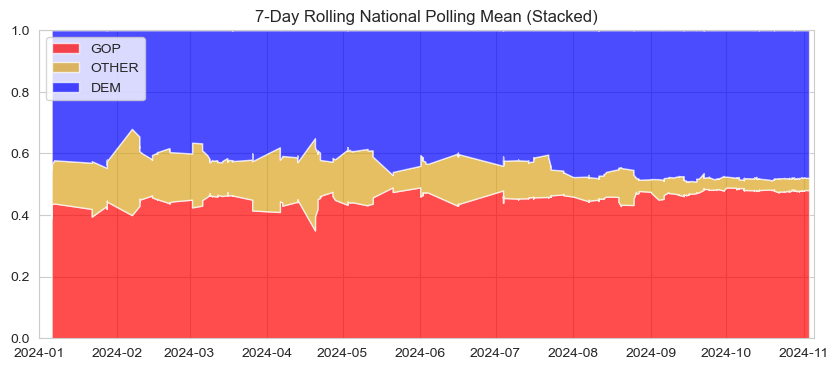

In [258]:
rolling_mean = (
    df.query(f"state in {swing_states}")[["date", "GOP", "OTHER", "DEM"]]
    .set_index("date")
    .sort_index()  # Ensure the index is sorted
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", "GOP", "OTHER", "DEM"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))

ax.stackplot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    rolling_mean.OTHER.values,
    rolling_mean.DEM.values,
    labels=["GOP", "OTHER", "DEM"],
    colors=['red', 'goldenrod', 'blue'],
    alpha=0.7,
)

ax.set_ylim(0, 1)  # Adjusted to fit the stacked plot
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_title("7-Day Rolling National Polling Mean (Stacked)")
ax.legend(loc='upper left')

plt.show()

We can see here that polling methodology is irrelevant, they all perform about the same.

In [259]:
df.query("state == 'US'").query("methodology in ['Online Panel','Live Phone','Probability Panel','Online Ad']")[['methodology','DEM','GOP','OTHER']].groupby("methodology").mean()

,DEM,GOP,OTHER
methodology,,,
Live Phone,0.438855,0.449987,0.111158
Online Ad,0.465333,0.487917,0.046750
Online Panel,0.448935,0.444746,0.106318
Probability Panel,0.428702,0.418469,0.152829


We can see that Trump fairly consistently under-performs on Probability Panel polls.

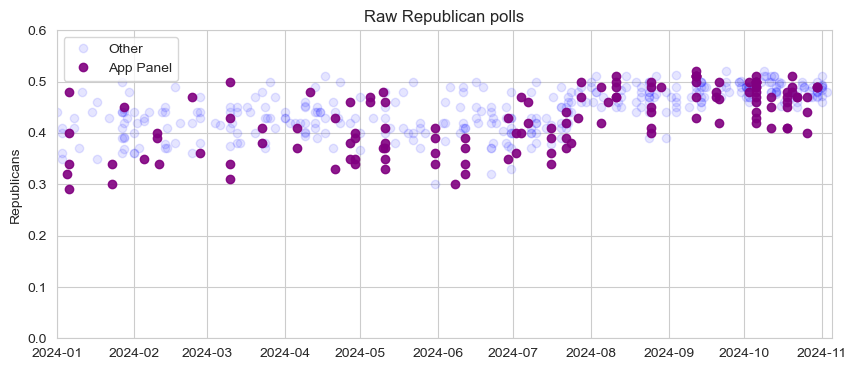

In [260]:
face = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == "Probability Panel"]
face = face.set_index("date")
dates_face = face.index

other = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] != "Probability Panel"]
other = other.set_index("date")
dates_other = other.index

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_other, other["DEM"].values, "o", alpha=0.1, color = 'blue', label="Other")
ax.plot(dates_face, face["DEM"].values, "o", alpha=.9, color = 'purple', label="App Panel")
ax.set_ylim(0, .6)
ax.set_ylabel("Republicans")
ax.set_title("Raw Republican polls")

ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.legend()

In [261]:
df["margin"] = df.apply(lambda row: (row['DEM'] - row['GOP']), axis=1)

df = (
    df.reset_index()
    .merge(
        df.groupby(["week","type"])[["GOP", "DEM", "margin"]].mean().reset_index(),
        on=["week","type"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

In [262]:
df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

In [263]:
x_res = np.maximum(df.query("state == 'US'").margin.quantile(q=1), df.query("state == 'US'").margin.quantile(q=0) * -1)

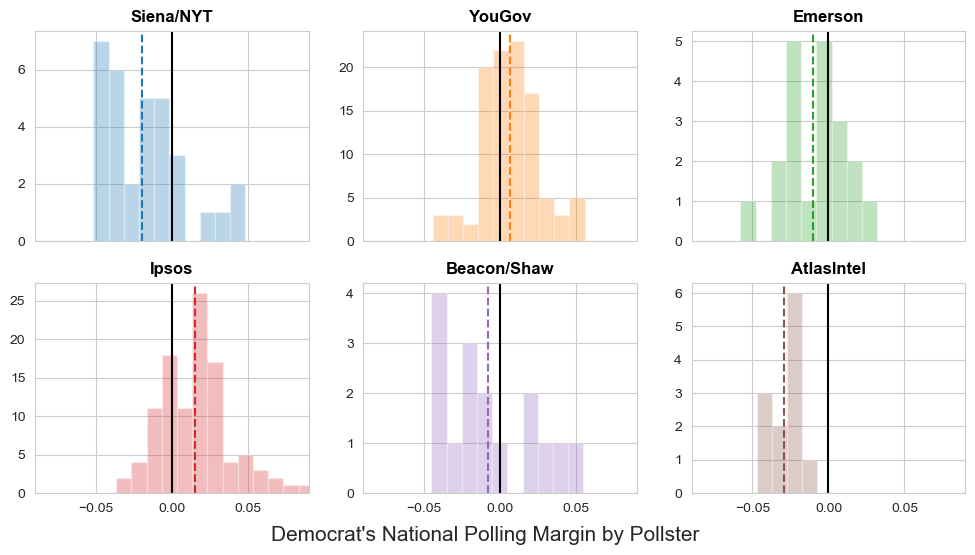

In [264]:
POLLSTER_VALS = {
    pollster: df.query("state == 'US'")[df.query("state == 'US'")["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=3, nrows=2, sharex=True, figsize=(12, 6))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    bin_width = 0.01
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-x_res, x_res)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 1.1, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.03, r"Democrat's National Polling Margin by Pollster", ha='center', fontsize=15)

plt.savefig('pollster_margin.png')
plt.show()

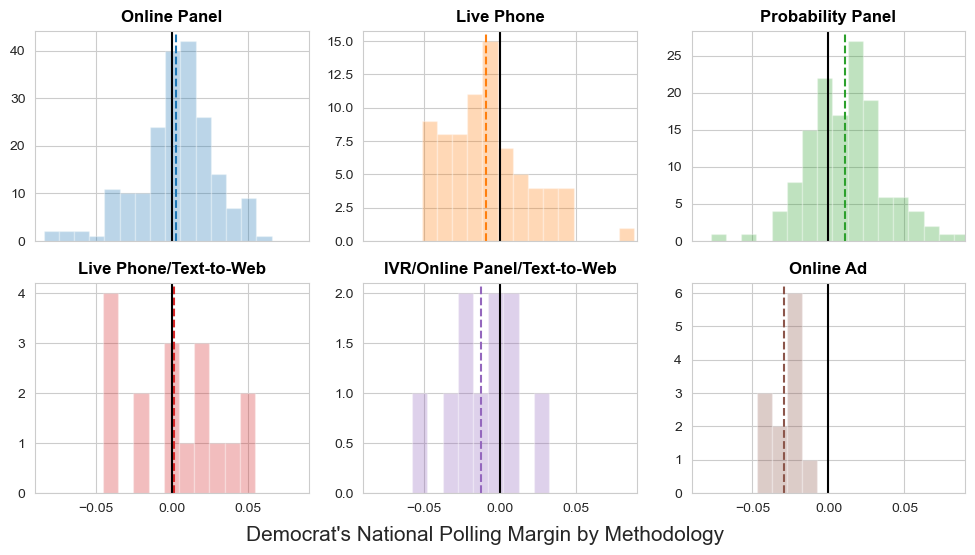

In [265]:
METHOD_VALS = {
    method: df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == method]["diff_margin"].values
    for method in list(METHODS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=3, nrows=2, sharex=True, figsize=(12, 6))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), METHOD_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    bin_width = 0.01
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-x_res, x_res)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 1.1, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.03, r"Democrat's National Polling Margin by Methodology", ha='center', fontsize=15)

plt.savefig('methodology_margin.png')
plt.show()

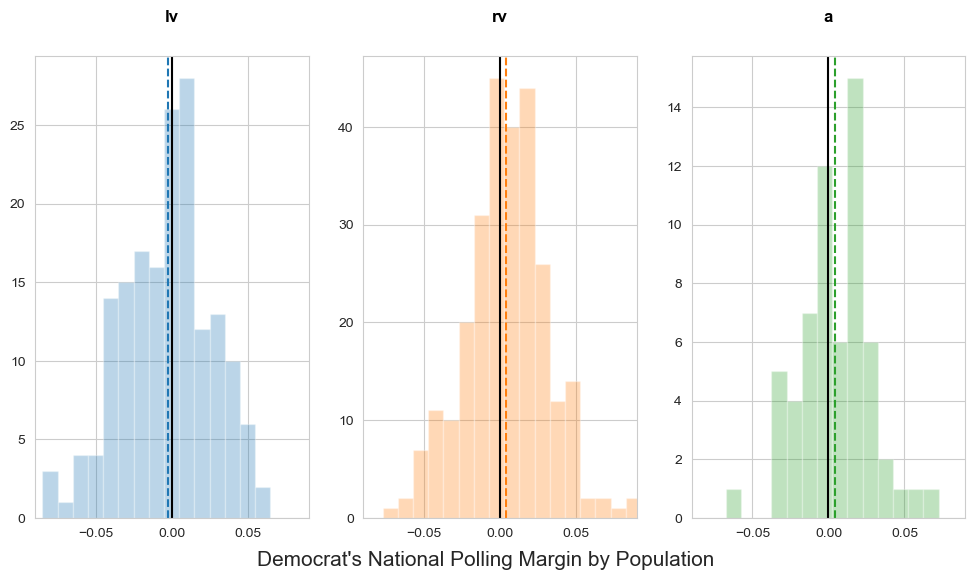

In [266]:
POPULATIONS_VALS = {
    population: df.query("state == 'US'")[df.query("state == 'US'")["population"] == population]["diff_margin"].values
    for population in list(POPULATIONS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, figsize=(12, 6))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POPULATIONS_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    bin_width = 0.01
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-x_res, x_res)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 1.1, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.03, r"Democrat's National Polling Margin by Population", ha='center', fontsize=15)

plt.savefig('population_margin.png')
plt.show()

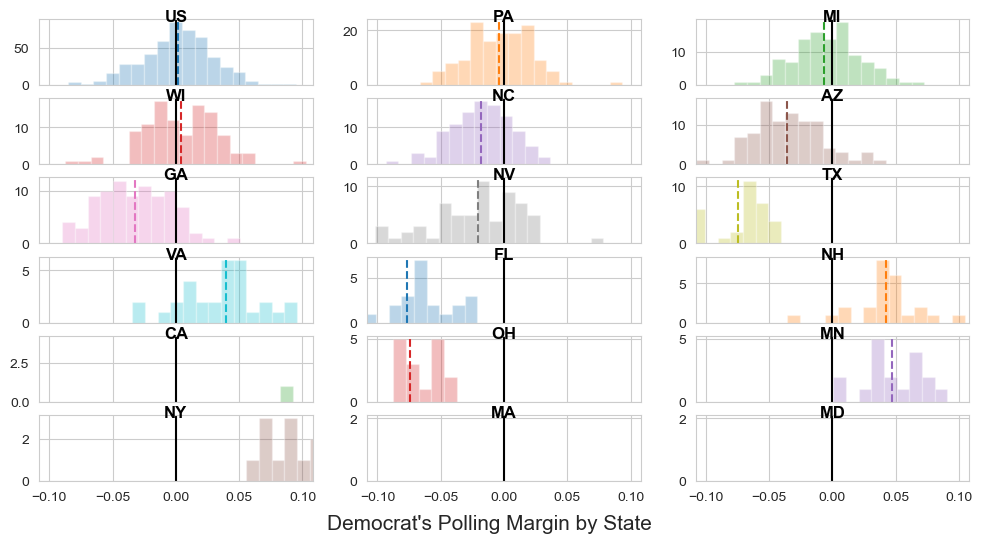

In [267]:
STATE_VALS = {
    state: df[df["state"] == state]["diff_margin"].values
    for state in list(STATES_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=3, nrows=6, sharex=True, figsize=(12, 6))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), STATE_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    bin_width = 0.01
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-x_res*1.2, x_res*1.2)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 1.15, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.03, r"Democrat's Polling Margin by State", ha='center', fontsize=15)

plt.savefig('state_margin.png')
plt.show()

In [268]:
mean = df.query(f"(state in {swing_states}) and (date < '2024-10-01') and (date >= '2024-08-01')").margin.mean()
std = df.query(f"(state in {swing_states}) and (date < '2024-10-01') and (date >= '2024-08-01')").margin.std()

mean2 = df.query(f"(state in {swing_states}) and (date >= '2024-10-01')").margin.mean()
std2 = df.query(f"(state in {swing_states}) and (date >= '2024-10-01')").margin.std()

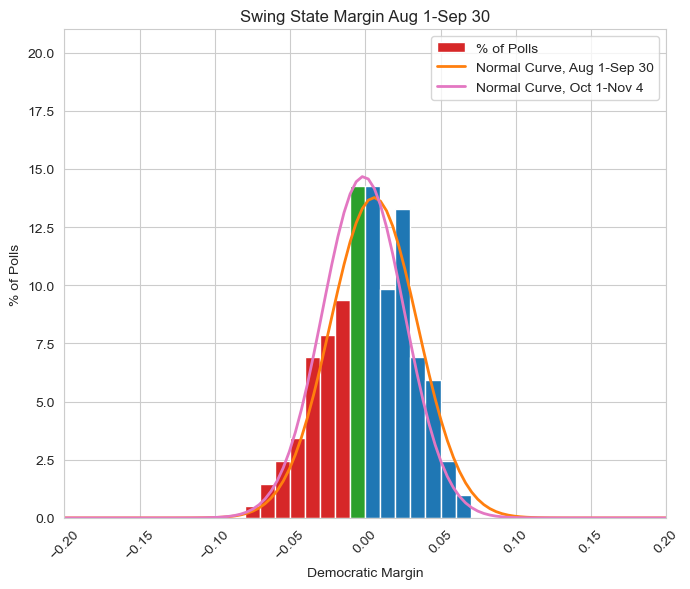

In [269]:
fig, ax = plt.subplots(figsize=(7, 6))

df.query(f"(state in {swing_states}) and (date < '2024-10-01') and (date >= '2024-08-01')").margin.hist(bins=np.arange(-0.20,0.20,0.01),density=True, ax=ax, label='% of Polls')

# Create an array of x values for the normal curve
x_values = np.linspace(-0.2, 0.2, 100)

# Get patches from the Axes
for patch in ax.patches:
    x = patch.get_x()
    
    # Set bar color based on x
    if x < -0.01:
        patch.set_facecolor('tab:red')
    elif x > 0:
        patch.set_facecolor('tab:blue')
    else:
        patch.set_facecolor('tab:green')

# Plot the normal curve
ax.plot(x_values, stats.norm.pdf(x_values, mean, std), color='tab:orange', linewidth=2, label='Normal Curve, Aug 1-Sep 30')

# Plot the normal curve
ax.plot(x_values, stats.norm.pdf(x_values, mean2, std2), color='tab:pink', linewidth=2, label='Normal Curve, Oct 1-Nov 4')

ax.set_xlim(-.2, .2)
ax.set_ylim(0, 21)
plt.xticks(rotation=45)

plt.xlabel('Democratic Margin')
plt.ylabel('% of Polls')
plt.title('Swing State Margin Aug 1-Sep 30')
plt.legend()

plt.tight_layout()
plt.savefig('herding_before.png')

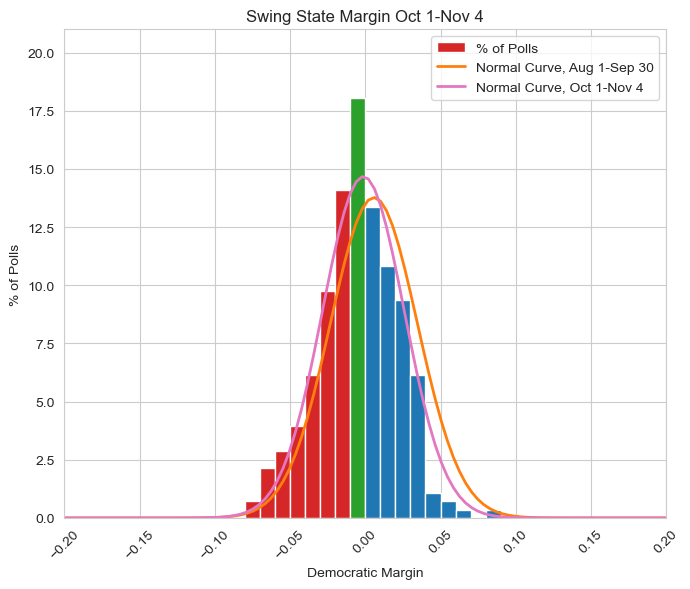

In [270]:
fig, ax = plt.subplots(figsize=(7, 6))

df.query(f"(state in {swing_states}) and (date >= '2024-10-01')").margin.hist(bins=np.arange(-0.20,0.20,0.01),density=True, ax=ax, label='% of Polls')

# Create an array of x values for the normal curve
x_values = np.linspace(-0.2, 0.2, 100)

# Get patches from the Axes
for patch in ax.patches:
    x = patch.get_x()
    
    # Set bar color based on x
    if x < -0.01:
        patch.set_facecolor('tab:red')
    elif x > 0:
        patch.set_facecolor('tab:blue')
    else:
        patch.set_facecolor('tab:green')

# Plot the normal curve
ax.plot(x_values, stats.norm.pdf(x_values, mean, std), color='tab:orange', linewidth=2, label='Normal Curve, Aug 1-Sep 30')

# Plot the normal curve
ax.plot(x_values, stats.norm.pdf(x_values, mean2, std2), color='tab:pink', linewidth=2, label='Normal Curve, Oct 1-Nov 4')

ax.set_xlim(-.2, .2)
ax.set_ylim(0, 21)
plt.xticks(rotation=45)

plt.xlabel('Democratic Margin')
plt.ylabel('% of Polls')
plt.title('Swing State Margin Oct 1-Nov 4')
plt.legend()

plt.tight_layout()
plt.savefig('herding_after.png')

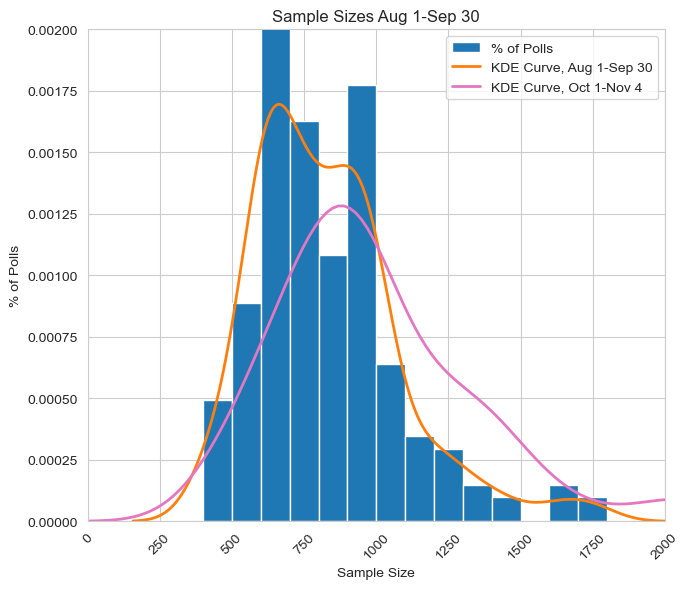

In [277]:
fig, ax = plt.subplots(figsize=(7, 6))

df.query(f"(state in {swing_states}) and (date < '2024-10-01') and (date >= '2024-08-01')").sample_size.hist(bins=np.arange(0,2000,100),density=True, ax=ax, label='% of Polls')

sns.kdeplot(df.query(f"(state in {swing_states}) and (date < '2024-10-01') and (date >= '2024-08-01')").sample_size, ax=ax, color='tab:orange', linewidth=2, label='KDE Curve, Aug 1-Sep 30')
sns.kdeplot(df.query(f"(state in {swing_states}) and (date >= '2024-10-01')").sample_size, ax=ax, color='tab:pink', linewidth=2, label='KDE Curve, Oct 1-Nov 4')

ax.set_xlim(0, 2000)
ax.set_ylim(0, .002)
plt.xticks(rotation=45)

plt.xlabel('Sample Size')
plt.ylabel('% of Polls')
plt.title('Sample Sizes Aug 1-Sep 30')
plt.legend()

plt.tight_layout()
plt.savefig('herding_sample_size_before.png')

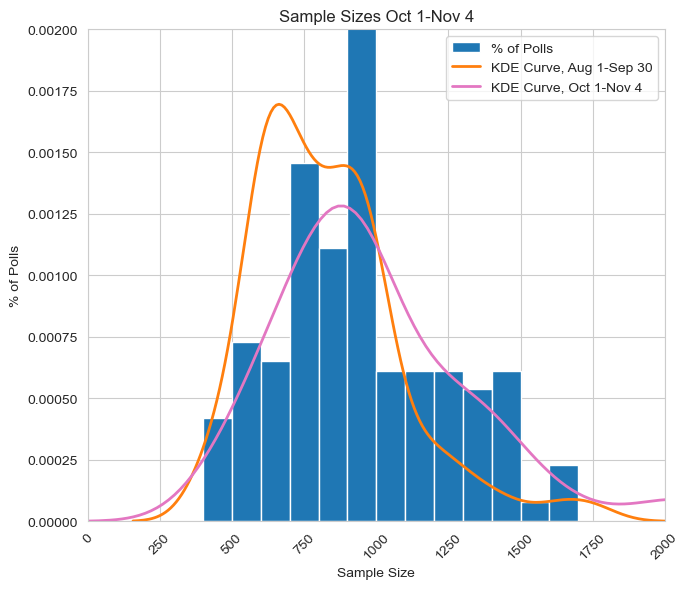

In [278]:
fig, ax = plt.subplots(figsize=(7, 6))

df.query(f"(state in {swing_states}) and (date >= '2024-10-01')").sample_size.hist(bins=np.arange(0,2000,100),density=True, ax=ax, label='% of Polls')

sns.kdeplot(df.query(f"(state in {swing_states}) and (date < '2024-10-01') and (date >= '2024-08-01')").sample_size, ax=ax, color='tab:orange', linewidth=2, label='KDE Curve, Aug 1-Sep 30')
sns.kdeplot(df.query(f"(state in {swing_states}) and (date >= '2024-10-01')").sample_size, ax=ax, color='tab:pink', linewidth=2, label='KDE Curve, Oct 1-Nov 4')

ax.set_xlim(0, 2000)
ax.set_ylim(0, .002)
plt.xticks(rotation=45)

plt.xlabel('Sample Size')
plt.ylabel('% of Polls')
plt.title('Sample Sizes Oct 1-Nov 4')
plt.legend()

plt.tight_layout()
plt.savefig('herding_sample_size_after.png')

In [273]:
(df.query(f"(state in {swing_states}) and (date < '2024-10-01') and (date >= '2024-08-01')").groupby("pollster").margin.std()-df.query(f"(state in {swing_states}) and (date >= '2024-10-01')").groupby("pollster").margin.std()).to_excel("pollster2.xlsx")

In [274]:
df.query(f"(state in {swing_states}) and (date >= '2024-08-01')").pollster.value_counts().to_excel("pollster.xlsx")

In [275]:
date_counts = df['date'].value_counts().reset_index()

# Rename the columns
date_counts.columns = ['date', 'count']

# Sort the DataFrame by date in descending order
date_counts = date_counts.sort_values(by='date', ascending=False).reset_index(drop=True)

In [276]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

#day_id, day = df.set_index(["day"]).index.factorize(sort=True)
day_id = df.day.to_numpy()
day = np.arange(df.day.min(), 1)

party_id, party = [0,1,2], ['DEM','GOP','Other']

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "state": state,
    "party": party,
    "population": population,
    "week": week,
    "day": day,
    "observation": df.obs_id
}

In [50]:
with pm.Model(coords=COORDS) as twoway:

    epsilon = 1e-6  # A small positive number for penalizing deviations

    dem_sigma       = pm.HalfNormal("dem_sigma", sigma=0.1) + epsilon
    dem_rho         = pm.Normal("dem_rho", mu=0, sigma=0.7)
    dem_ar          = pm.AR("dem_ar",
                            rho=[dem_rho] * 7,
                            sigma=dem_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    dem_sigma_rw    = pm.HalfNormal("dem_sigma_rw", sigma=0.1) + epsilon
    dem_random_walk = pm.GaussianRandomWalk("dem_random_walk",
                                            sigma=dem_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    dem_day_effect  = pm.Deterministic("dem_day_effect", dem_ar + dem_random_walk, dims="day")

    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.5, dims="pollster")
    dem_method_effect   = pm.Normal("dem_method_effect", 0, 0.5, dims="method")
    dem_state_effect    = pm.Normal("dem_state_effect", 0, 0.5, dims="state")
    dem_state_multi     = pm.Normal("dem_state_multi", 1, 0.5, dims="state")
    dem_pop_effect      = pm.Normal("dem_pop_effect", 0, 0.5, dims="population")

    dem_polling = pm.Deterministic("dem_polling", pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_method_effect[method_id] +
        dem_pop_effect[population_id] +
        dem_state_effect[state_id] +
        dem_state_multi[state_id] *
        dem_day_effect[day_id]
    ),
        dims = "observation")
    
    gop_sigma       = pm.HalfNormal("gop_sigma", sigma=0.1) + epsilon
    gop_rho         = pm.Normal("gop_rho", mu=0, sigma=0.7)
    gop_ar          = pm.AR("gop_ar",
                            rho=[gop_rho] * 7,
                            sigma=gop_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    gop_sigma_rw    = pm.HalfNormal("gop_sigma_rw", sigma=0.1) + epsilon
    gop_random_walk = pm.GaussianRandomWalk("gop_random_walk",
                                            sigma=gop_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    gop_day_effect  = pm.Deterministic("gop_day_effect", gop_ar + gop_random_walk, dims="day")

    gop_pollster_effect = pm.Normal("gop_pollster_effect", 0, 0.5, dims="pollster")
    gop_method_effect   = pm.Normal("gop_method_effect", 0, 0.5, dims="method")
    gop_state_effect    = pm.Normal("gop_state_effect", 0, 0.5, dims="state")
    gop_state_multi     = pm.Normal("gop_state_multi", 1, 0.5, dims="state")
    gop_pop_effect      = pm.Normal("gop_pop_effect", 0, 0.5, dims="population")

    gop_polling = pm.Deterministic("gop_polling", pm.math.invlogit(
        gop_pollster_effect[pollster_id] +
        gop_method_effect[method_id] +
        gop_pop_effect[population_id] +
        gop_state_effect[state_id] +
        gop_state_multi[state_id] *
        gop_day_effect[day_id]
    ),
        dims = "observation")

    oth_sigma       = pm.HalfNormal("oth_sigma", sigma=0.1) + epsilon
    oth_rho         = pm.Normal("oth_rho", mu=0, sigma=0.7)
    oth_ar          = pm.AR("oth_ar",
                            rho=[oth_rho] * 7,
                            sigma=oth_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    oth_sigma_rw    = pm.HalfNormal("oth_sigma_rw", sigma=0.1) + epsilon
    oth_random_walk = pm.GaussianRandomWalk("oth_random_walk",
                                            sigma=oth_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    oth_day_effect  = pm.Deterministic("oth_day_effect", oth_ar + oth_random_walk, dims="day")

    oth_pollster_effect = pm.Normal("oth_pollster_effect", 0, 0.5, dims="pollster")
    oth_method_effect   = pm.Normal("oth_method_effect", 0, 0.5, dims="method")
    oth_state_effect    = pm.Normal("oth_state_effect", 0, 0.5, dims="state")
    oth_state_multi     = pm.Normal("oth_state_multi", 1, 0.5, dims="state")
    oth_pop_effect      = pm.Normal("oth_pop_effect", 0, 0.5, dims="population")

    oth_polling = pm.Deterministic("oth_polling", pm.math.invlogit(
        oth_pollster_effect[pollster_id] +
        oth_method_effect[method_id] +
        oth_pop_effect[population_id] +
        oth_state_effect[state_id] +
        oth_state_multi[state_id] *
        oth_day_effect[day_id]
    ),
        dims = "observation")

    # Binomial likelihoods
    dem_vote = pm.Binomial(
        "dem_vote",
        p = dem_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['DEM'],
        dims = "observation",
    )

    gop_vote = pm.Binomial(
        "gop_vote",
        p = gop_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['GOP'],
        dims = "observation",
    )

    oth_vote = pm.Binomial(
        "oth_vote",
        p = oth_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['OTHER'],
        dims = "observation",
    )

    polling_error_state_dem = pm.Normal("polling_error_state_dem", 0, 1, dims="state")
    polling_error_state_gop = pm.Deterministic("polling_error_state_gop", -polling_error_state_dem, dims="state")
    polling_error_state_oth = pm.Deterministic("polling_error_state_oth", polling_error_state_dem*0, dims="state")

    # Sampling
    idata = pm.sample(draws=1000, cores=10, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

Multiprocess sampling (10 chains in 10 jobs)
NUTS: [dem_sigma, dem_rho, dem_ar, dem_sigma_rw, dem_random_walk, dem_pollster_effect, dem_method_effect, dem_state_effect, dem_state_multi, dem_pop_effect, gop_sigma, gop_rho, gop_ar, gop_sigma_rw, gop_random_walk, gop_pollster_effect, gop_method_effect, gop_state_effect, gop_state_multi, gop_pop_effect, oth_sigma, oth_rho, oth_ar, oth_sigma_rw, oth_random_walk, oth_pollster_effect, oth_method_effect, oth_state_effect, oth_state_multi, oth_pop_effect, polling_error_state_dem]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 2945 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 4 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 6 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 7 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 8 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 9 rea

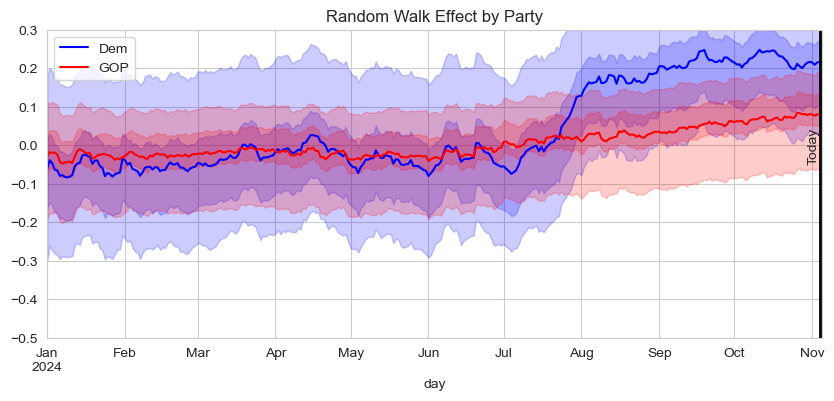

In [51]:
rw = pd.DataFrame()
rw['day'] = pd.date_range(start=df.date.min(), end='2024-11-05')

for party in ['dem', 'gop', 'oth']:
    rw[f"{party}_50"] = idata.posterior[f"{party}_day_effect"].median(dim=["chain", "draw"]).values * idata.posterior[f"{party}_state_multi"].mean(axis=0).mean(axis=0).mean(axis=0).values
    rw[[f"{party}_03",f"{party}_97"]] = az.hdi(idata.posterior[f"{party}_day_effect"], hdi_prob=0.94)[f"{party}_day_effect"]* idata.posterior[f"{party}_state_multi"].mean(axis=0).mean(axis=0).mean(axis=0).values
    rw[[f"{party}_25",f"{party}_75"]] = az.hdi(idata.posterior[f"{party}_day_effect"], hdi_prob=0.50)[f"{party}_day_effect"]* idata.posterior[f"{party}_state_multi"].mean(axis=0).mean(axis=0).mean(axis=0).values

rw = rw.set_index('day')

rolling_mean = (
    rw
    .rolling(window='7D')
    .mean()
)

fig, ax = plt.subplots(figsize=(10, 4))

for party, color, abb in [('dem', 'blue', 'Dem'), ('gop', 'red', 'GOP')]:
    
    rolling_mean[f"{party}_50"].plot(color=f"{color}", label=f'{abb}')
    plt.fill_between(rw.index, rolling_mean[f"{party}_03"].ffill(), rolling_mean[f"{party}_97"].ffill(), color=f"{color}", alpha=0.2)
    plt.fill_between(rw.index, rolling_mean[f"{party}_25"].ffill(), rolling_mean[f"{party}_75"].ffill(), color=f"{color}", alpha=0.2)
    
ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_ylim(-.5,.3)
ax.set_title("Random Walk Effect by Party")
ax.legend()

plt.show()

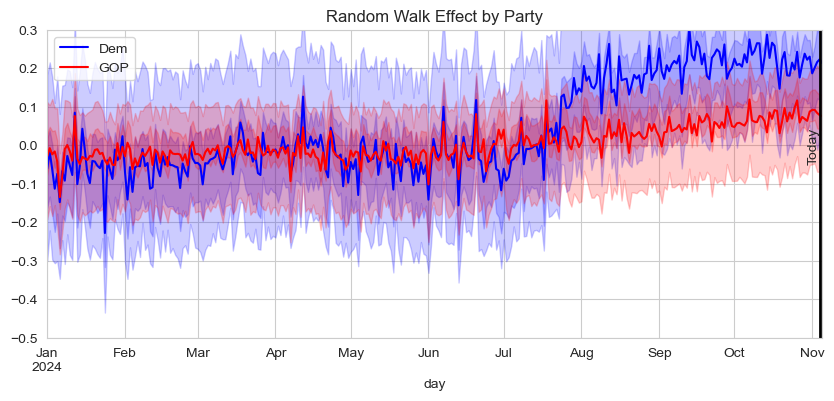

In [52]:
fig, ax = plt.subplots(figsize=(10, 4))

for party, color, abb in [('dem', 'blue', 'Dem'), ('gop', 'red', 'GOP')]:
    
    rw[f"{party}_50"].plot(color=f"{color}", label=f'{abb}')
    plt.fill_between(rw.index, rw[f"{party}_03"].ffill(), rw[f"{party}_97"].ffill(), color=f"{color}", alpha=0.2)
    plt.fill_between(rw.index, rw[f"{party}_25"].ffill(), rw[f"{party}_75"].ffill(), color=f"{color}", alpha=0.2)
    
ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_ylim(-.5,.3)
ax.set_title("Random Walk Effect by Party")
ax.legend()

plt.show()

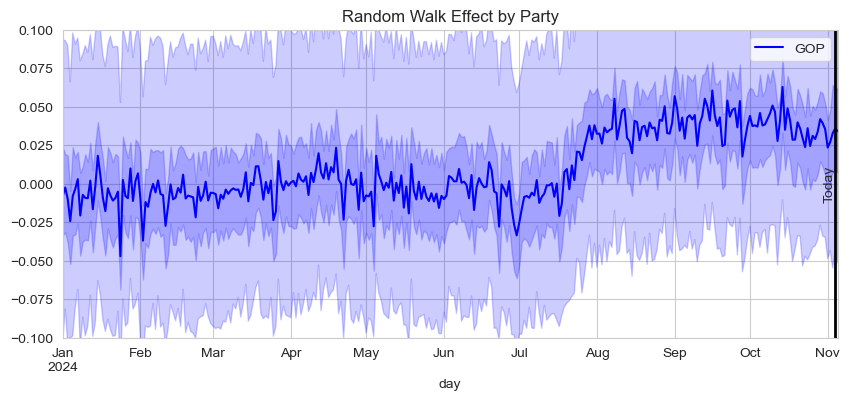

In [53]:
fig, ax = plt.subplots(figsize=(10, 4))
    
(inv_logit(rw.dem_50) - inv_logit(rw.gop_50)).plot(color='blue', label=f'{abb}')
plt.fill_between(rw.index, (inv_logit(rw.dem_03) - inv_logit(rw.gop_97)).ffill(), (inv_logit(rw.dem_97) - inv_logit(rw.gop_03)).ffill(), color='blue', alpha=0.2)
plt.fill_between(rw.index, (inv_logit(rw.dem_25) - inv_logit(rw.gop_50)).ffill(), (inv_logit(rw.dem_75) - inv_logit(rw.gop_25)).ffill(), color='blue', alpha=0.2)
    
ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_ylim(-.1,.1)
ax.set_title("Random Walk Effect by Party")
ax.legend()

plt.show()

In [54]:
states = df['state'].unique()
parties = ['dem','gop','margin','oth']

combinations = [f"{state}_{party}" for state, party in product(states, parties)]

In [55]:
df.pollster.value_counts().head(30)

pollster
Siena/NYT                                    178
YouGov                                       169
Emerson                                      148
Ipsos                                        106
Beacon/Shaw                                   88
AtlasIntel                                    82
Marist                                        62
Quinnipiac                                    60
Echelon Insights                              47
Noble Predictive Insights                     29
Marquette Law School                          29
CES / YouGov                                  28
CNN/SSRS                                      28
SurveyUSA                                     24
RMG Research                                  24
Washington Post/George Mason University       20
Suffolk                                       18
Leger                                         17
Mitchell                                      14
Hart/POS                                      14
Siena      

In [173]:
interim = pd.DataFrame()

for party in ['dem', 'gop', 'oth']:
    pollster_effects = (
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Siena/NYT") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Marquette Law School") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Marist") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Suffolk") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Emerson") #+
        #idata.posterior[f"{party}_pollster_effect"].sel(pollster="CNN/SSRS")
    ).values / 5
    pollster_effects_flat = pollster_effects.ravel()
    interim[f"pollster_effects_{party}"] = pollster_effects_flat

    method_effects = (
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2) +
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Probability Panel', drop=True).mean(axis=2)
    ).values /2
    method_effects_flat = method_effects.ravel()
    interim[f"method_effects_{party}"] = method_effects_flat

    pop_effects = (
        idata.posterior[f"{party}_pop_effect"].sel(population="lv")
    ).values
    pop_effects_flat = pop_effects.ravel()
    interim[f"pop_effects_{party}"] = pop_effects_flat

    interim[f"fund_{party}"] = interim[f"pollster_effects_{party}"] + interim[f"method_effects_{party}"] + interim[f"pop_effects_{party}"]

In [174]:
df_results = pd.DataFrame(columns=combinations)
df_day_mean = pd.DataFrame(index=day, columns=combinations)
df_day_03 =  pd.DataFrame(index=day, columns=combinations)
df_day_25 =  pd.DataFrame(index=day, columns=combinations)
df_day_75 =  pd.DataFrame(index=day, columns=combinations)
df_day_97 =  pd.DataFrame(index=day, columns=combinations)

#for d in [-5]:
for d in tqdm(day):
    day_results = {}
    for state in states:
        for party in ['dem', 'gop', 'oth']:
            polling_error = 0.067 * idata.posterior[f"polling_error_state_{party}"].sel(state=f"{state}").values.ravel() if state == 'US' else 0.067 * idata.posterior[f"polling_error_state_{party}"].sel(state=f"{state}").values.ravel()
            day_results[f"{state}_{party}"] = inv_logit(
                interim[f"fund_{party}"] +
                idata.posterior[f"{party}_state_effect"].sel(state=f"{state}").values.ravel() +
                polling_error +
                idata.posterior[f"{party}_state_multi"].sel(state=f"{state}").values.ravel() *
                (idata.posterior[f"{party}_day_effect"].sel(day=d).values.ravel()
                #+ (.1 if party == 'gop' else 0) # 2% swing towards GOP
                #+ (.175 if party == 'dem' else 0) # 5% swing towards DEM
                )  
            ).to_numpy()

        # Calculate total votes and normalize
        total = sum(day_results[f"{state}_{party}"] for party in ['dem', 'gop', 'oth'])
        for party in ['dem', 'gop', 'oth']:
            day_results[f"{state}_{party}"] /= total
        
        # Calculate margin
        day_results[f"{state}_margin"] = day_results[f"{state}_dem"] - day_results[f"{state}_gop"]

    # Convert day_results to DataFrame
    df_results = pd.DataFrame(day_results)

    # Store quantiles and mean for this day
    df_day_03.loc[d] = df_results.quantile(0.03)
    df_day_25.loc[d] = df_results.quantile(0.25)
    df_day_mean.loc[d] = df_results.quantile(0.50)
    df_day_75.loc[d] = df_results.quantile(0.75)
    df_day_97.loc[d] = df_results.quantile(0.97)

100%|█████████████████████████████████████████| 310/310 [00:25<00:00, 12.35it/s]


In [175]:
date_index = pd.DataFrame(index = range(min(df_day_mean.index),1), columns = ['date'])
date_index['date'] = pd.date_range(start=df.date.min(), end='2024-11-05')
df_day_mean = df_day_mean.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_03 = df_day_03.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_25 = df_day_25.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_75 = df_day_75.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_97 = df_day_97.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')

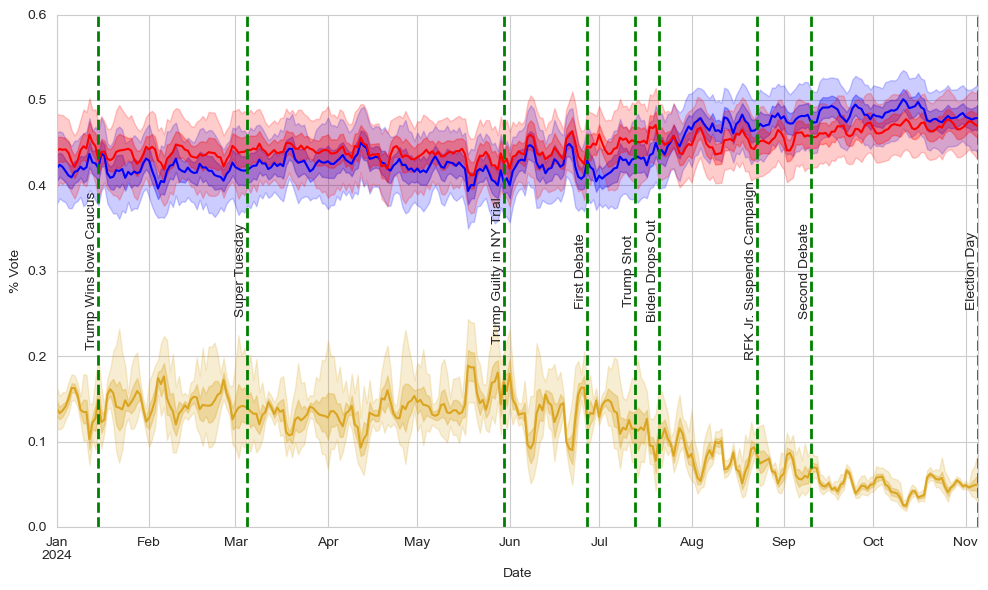

In [222]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].rolling(window='3D').mean().plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].rolling(window='3D').mean().ffill(), df_day_97[f"{graph_state}_dem"].rolling(window='3D').mean().ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].rolling(window='3D').mean().ffill(), df_day_75[f"{graph_state}_dem"].rolling(window='3D').mean().ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].rolling(window='3D').mean().plot(color='red', label='GOP Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].rolling(window='3D').mean().ffill(), df_day_97[f"{graph_state}_gop"].rolling(window='3D').mean().ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].rolling(window='3D').mean().ffill(), df_day_75[f"{graph_state}_gop"].rolling(window='3D').mean().ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

df_day_mean[f"{graph_state}_oth"].rolling(window='3D').mean().plot(color='goldenrod', label='Other Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_oth"].rolling(window='3D').mean().ffill(), df_day_97[f"{graph_state}_oth"].rolling(window='3D').mean().ffill(), color='goldenrod', alpha=0.2, label='OTH 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_oth"].rolling(window='3D').mean().ffill(), df_day_75[f"{graph_state}_oth"].rolling(window='3D').mean().ffill(), color='goldenrod', alpha=0.3, label='OTH 50% HDI')

dem_votes = df.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df.set_index('date').query(f"state == '{graph_state}'")["GOP"]
oth_votes = df.set_index('date').query(f"state == '{graph_state}'")["OTHER"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=1, markersize=3, color='blue', label="Poll Dem., %")
#ax.plot(gop_votes.index, gop_votes, "o", alpha=1, markersize=3, color='red', label="Poll GOP %")
#ax.plot(oth_votes.index, oth_votes, "o", alpha=1, markersize=3, color='goldenrod', label="Poll Other %")

# Set limits and labels
ax.set_ylim(0,.6)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
#ax.legend(loc='center left', bbox_to_anchor=(0, 0.5))
#ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2024, 1, 15), 'Trump Wins Iowa Caucus'),
            (dt.datetime(2024, 3, 5),  'Super Tuesday'),
            (dt.datetime(2024, 5, 30), 'Trump Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Debate'),
            (dt.datetime(2024, 7, 13), 'Trump Shot'),
            (dt.datetime(2024, 7, 21), 'Biden Drops Out'),
            (dt.datetime(2024, 8, 23), 'RFK Jr. Suspends Campaign'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.3, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)
    
plt.tight_layout()
plt.savefig('2way_enight_natpoll.png')

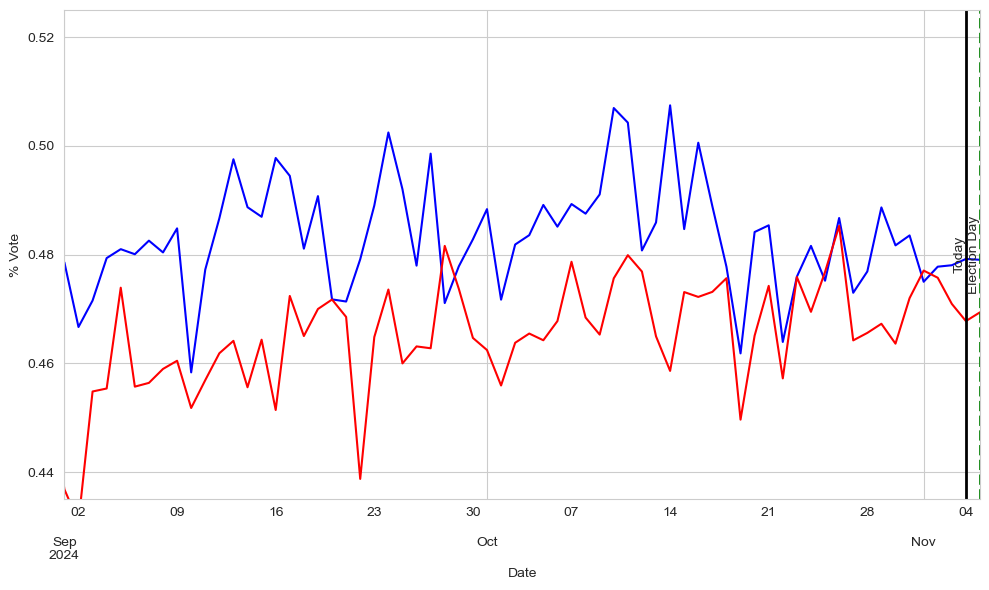

In [177]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].rolling(window='1D').mean().plot(color='blue', label='Democrats Mean')
#plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].rolling(window='7D').mean().ffill(), df_day_97[f"{graph_state}_dem"].rolling(window='7D').mean().ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
#plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].rolling(window='7D').mean().ffill(), df_day_75[f"{graph_state}_dem"].rolling(window='7D').mean().ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].rolling(window='1D').mean().plot(color='red', label='GOP Mean')
#plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].rolling(window='7D').mean().ffill(), df_day_97[f"{graph_state}_gop"].rolling(window='7D').mean().ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
#plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].rolling(window='7D').mean().ffill(), df_day_75[f"{graph_state}_gop"].rolling(window='7D').mean().ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

df_day_mean[f"{graph_state}_oth"].rolling(window='1D').mean().plot(color='goldenrod', label='Other Mean')
#plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_oth"].rolling(window='7D').mean().ffill(), df_day_97[f"{graph_state}_oth"].rolling(window='7D').mean().ffill(), color='goldenrod', alpha=0.2, label='OTH 94% HDI')
#plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_oth"].rolling(window='7D').mean().ffill(), df_day_75[f"{graph_state}_oth"].rolling(window='7D').mean().ffill(), color='goldenrod', alpha=0.3, label='OTH 50% HDI')

#dem_votes = df.set_index('date').query(f"state == '{graph_state}'")["DEM"]
#gop_votes = df.set_index('date').query(f"state == '{graph_state}'")["GOP"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=.5, markersize=3, color='blue', label="Poll Dem., %")
#ax.plot(gop_votes.index, gop_votes, "o", alpha=.5, markersize=3, color='red', label="Poll GOP %")
#ax.plot(oth_votes.index, oth_votes, "o", alpha=.5, markersize=3, color='goldenrod', label="Poll Other %")

# Set limits and labels
ax.set_ylim(0.435,.525)
ax.set_xlim(dt.datetime(2024, 9, 1), dt.datetime(2024, 11, 5))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
#ax.legend(loc='center left', bbox_to_anchor=(0, 0.5))
#ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.48, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)
    
ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.48, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

plt.tight_layout()
plt.savefig('2way_enight_natpoll_zoom.png')

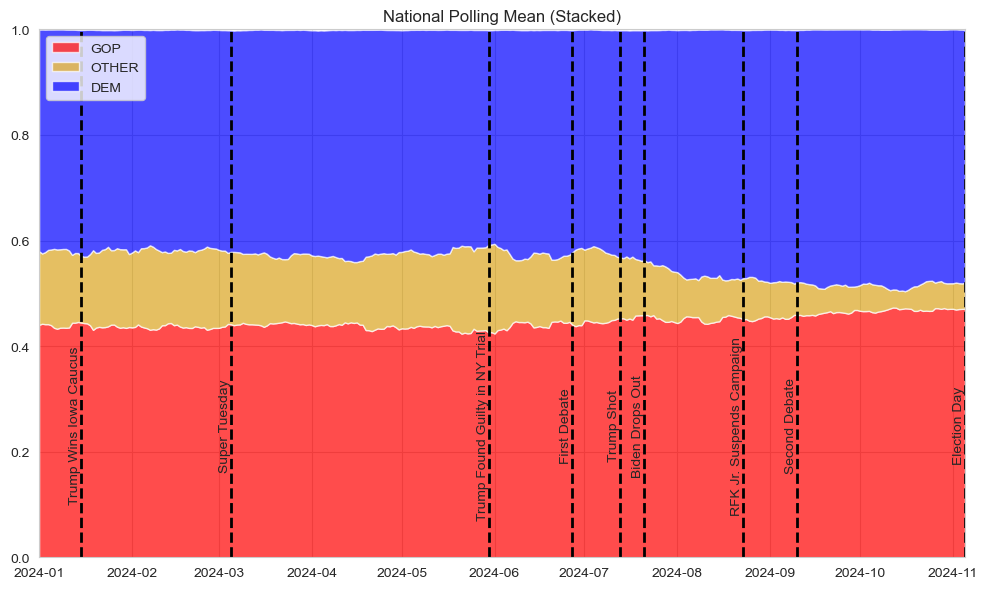

In [214]:
graph_state = 'US'

rolling_mean = (
    df_day_mean[[f"{graph_state}_gop", f"{graph_state}_oth", f"{graph_state}_dem"]]
    .sort_index()  # Ensure the index is sorted
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", f"{graph_state}_gop", f"{graph_state}_oth", f"{graph_state}_dem"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.stackplot(
    rolling_mean.date,
    rolling_mean[f"{graph_state}_gop"].values,
    rolling_mean[f"{graph_state}_oth"].values,
    rolling_mean[f"{graph_state}_dem"].values,
    labels=["GOP", "OTHER", "DEM"],
    colors=['red', 'goldenrod', 'blue'],
    alpha=0.7,
)

ax.set_ylim(0, 1)  # Adjusted to fit the stacked plot
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_title("National Polling Mean (Stacked)")
ax.legend(loc='upper left')

events = [
            (dt.datetime(2024, 1, 15), 'Trump Wins Iowa Caucus'),
            (dt.datetime(2024, 3, 5),  'Super Tuesday'),
            (dt.datetime(2024, 5, 30), 'Trump Found Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Debate'),
            (dt.datetime(2024, 7, 13), 'Trump Shot'),
            (dt.datetime(2024, 7, 21), 'Biden Drops Out'),
            (dt.datetime(2024, 8, 23), 'RFK Jr. Suspends Campaign'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='black', linestyle='--', linewidth=2)
    plt.text(date, 0.25, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

plt.tight_layout()
plt.savefig('stacked.png')

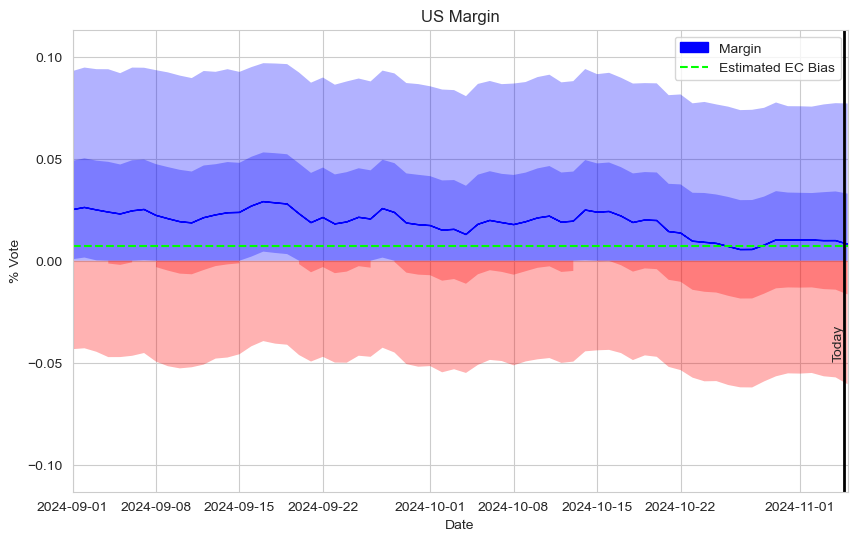

In [213]:
graph_state = 'US'

# Assuming df_day_mean, df_day_97, df_day_03, df_day_75, and df_day_25 are DataFrames
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the rolling means for each DataFrame and ensure no NaNs
mean_rolling = df_day_mean[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_03_rolling = df_day_03[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_97_rolling = df_day_97[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_25_rolling = df_day_25[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_75_rolling = df_day_75[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()

#dem_votes = df.set_index('date').query(f"state == '{graph_state}'")["DEM"] - df.set_index('date').query(f"state == '{graph_state}'")["GOP"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=.5, markersize=1, color='black', label="Polls")

# Plot 94% HDI

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,hdi_03_rolling), 
                 np.maximum(hdi_97_rolling,0),
                 where=hdi_97_rolling > 0, 
                 color='blue', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,hdi_25_rolling), 
                 np.maximum(hdi_75_rolling,0), 
                 where=hdi_75_rolling > 0, 
                 color='blue', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,mean_rolling), 
                 np.maximum(mean_rolling,0), 
                 where=mean_rolling > 0, 
                 color='blue', alpha=1, label='Margin')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,hdi_03_rolling), 
                 np.minimum(hdi_97_rolling,0),
                 where=hdi_03_rolling < 0, 
                 color='red', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,hdi_25_rolling), 
                 np.minimum(hdi_75_rolling,0), 
                 where=hdi_25_rolling < 0, 
                 color='red', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,mean_rolling), 
                 np.minimum(mean_rolling,0), 
                 where=mean_rolling < 0, 
                 color='red', alpha=1)

# Set axis limits and labels
y_res = np.maximum((min(hdi_03_rolling)-.01)*-1, max(hdi_97_rolling)+.01)
ax.set_ylim(-y_res, y_res)
ax.set_xlim(dt.datetime(2024, 9, 1), dt.datetime(2024, 11, 5))  # Fix xlim parenthesis

plt.axhline(y=0.0072, color='lime', linestyle='--', label="Estimated EC Bias")
    
ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), -.04, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.set_title(f'{graph_state} Margin')
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')

plt.savefig(f'{graph_state}_margin.png')
ax.legend()

In [180]:
# List of states to loop over
state_loop = ['TX', 'CA', 'MN', 'MI', 'FL', 'GA', 'US','WI','PA','AZ','NV','NC', 'NY', 'OH']

# Loop over each state
for state in state_loop:
    graph_state = state
    
    # Create a new figure for each state
    plt.figure(figsize=(10, 6))
    
    # Define the bin edges, ensuring that they align perfectly
    bin_edges = np.arange(-0.3, 0.31, 0.01)
    
    # Plot the histogram using the pre-defined bins
    ax = sns.histplot(df_results[f"{graph_state}_margin"], bins=bin_edges, kde=False, stat="probability")
    
    # Get patches from the Axes
    for patch in ax.patches:
        # Get x midpoint of bar
        x = patch.get_x() + 0.5 * patch.get_width()
        
        # Set bar color based on x
        if x < 0:
            patch.set_facecolor('red')
        elif x > 0:
            patch.set_facecolor('blue')
        elif x == 0:
            patch.set_facecolor('lime')
    
    # Add titles and labels
    plt.title(f'2024 - {state} Margin')
    plt.xlabel('Democratic Margin')
    plt.xlim(-0.3, 0.3)
    plt.ylabel('Probability')
        
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'2way_enight_{state.lower()}.png')
    
    # Close the figure to avoid overlapping
    plt.close()


In [225]:
df_results.to_csv("2024_model_results.csv")

In [181]:
df_winner = pd.DataFrame(columns=states)

for state in states:
    # Get values for the current state
    dem_votes = df_results[f"{state}_dem"]
    gop_votes = df_results[f"{state}_gop"]
    
    # Compare votes and determine winner
    df_winner[state] = pd.Series(
        ["dem" if dem_votes[i] > gop_votes[i]
         else "gop" if gop_votes[i] > dem_votes[i]
         else "tie"
         for i in range(len(df_results))]
    )

In [182]:
df_state['state_code'][~df_state['state_code'].isin(df_winner.columns)]

0       AL
1       AK
3       AR
5       CO
6       CT
7       DE
8       DC
11      HI
12      ID
13      IL
14      IN
15      IA
16      KS
17      KY
18      LA
19      ME
20    ME-1
21    ME-2
26      MS
27      MO
30      NE
31    NE-1
33    NE-3
36      NJ
37      NM
40      ND
42      OK
43      OR
45      RI
46      SC
47      SD
48      TN
50      UT
51      VT
53      WA
54      WV
56      WY
Name: state_code, dtype: object

In [183]:
df_winner[[
    'AL',
    'AK',
    'AR',
    'ID',
    'IN',
    'IA',
    'KS',
    'KY',
    'LA',
    'ME-2',
    'MS',
    'MO',
    'NE',
    'NE-1',
    'NE-3',
    'ND',
    'OK',
    'SC',
    'SD',
    'TN',
    'UT',
    'WV',
    'WY',
    ]] = 'gop'

df_winner[[
    'CO',
    'CT',
    'DE',
    'DC',
    'HI',
    'IL',
    'ME',
    'ME-1',
    'NJ',
    'NM',
    'OR',
    'RI',
    'VT',
    'WA',
    ]] = 'dem'

state_order = df_state['state_code'].to_list

In [184]:
df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_93510/586220177.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_93510/586220177.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})


In [185]:
df_ec = pd.DataFrame()
df_ec['dem'] = df_winner_dem.mul(df_state[['state_code', 'electoral_2024']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['gop'] = df_winner_gop.mul(df_state[['state_code', 'electoral_2024']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['dem_pop'] = df_winner_dem['US']
df_ec['gop_pop'] = df_winner_gop['US']
df_ec['dem_ec'] = np.where(df_ec['dem'] >= 270, 1, 0)
df_ec['gop_ec'] = np.where(df_ec['gop'] >= 270, 1, 0)
df_ec['tie_ec'] = np.where(df_ec['dem'] == 269, 1, 0)

In [186]:
# Calculate the total number of rows
total_rows = len(df_ec)

# Calculate the number of rows greater than, equal to, and lower than 270
greater_than_270 = len(df_ec[df_ec['dem'] > 269])
equal_to_270 = len(df_ec[df_ec['dem'] == 269])
lower_than_270 = len(df_ec[df_ec['dem'] < 269])

# Calculate the percentages
percent_greater_than_270 = (greater_than_270 / total_rows) * 100
percent_equal_to_270 = (equal_to_270 / total_rows) * 100
percent_lower_than_270 = (lower_than_270 / total_rows) * 100

percent_greater_than_270, percent_equal_to_270, percent_lower_than_270

(51.970000000000006, 0.8099999999999999, 47.22)

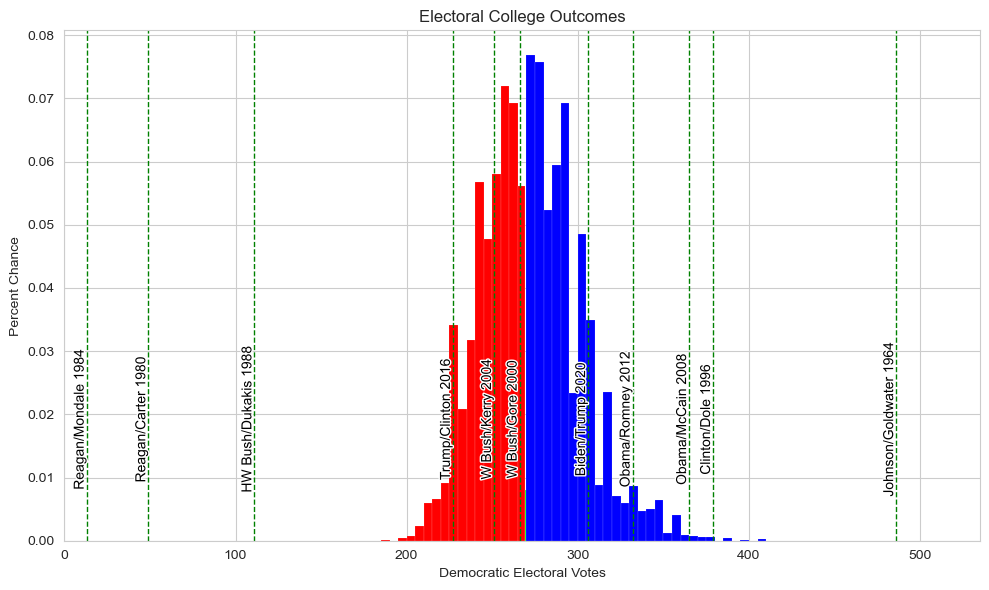

In [187]:
plt.figure(figsize=(10, 6))

bins = list(range(0, 269, 5)) + [269] + list(range(270, 540, 5))

# Use sns.histplot to plot the histogram
ax = sns.histplot(df_ec['dem'], bins=bins, kde=False, stat="probability")

# Get patches from the Axes
max_height = max([patch.get_height() for patch in ax.patches])

# Get the lowest and highest x values from the histogram bars
lowest_bar = min([patch.get_x() for patch in ax.patches])
highest_bar = max([patch.get_x() + patch.get_width() for patch in ax.patches])

# Get patches from the Axes
for patch in ax.patches:
    # Get x midpoint of bar
    x = patch.get_x() #+ 0.5 * patch.get_width()
    
    # Set bar color based on x
    if x < 269:
        patch.set_facecolor('red')
    elif x > 269:
        patch.set_facecolor('blue')
    elif x == 269:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('lime')

# Adding titles and labels
#plt.title('2024 Election Night - Electoral College Results')
plt.title('Electoral College Outcomes')
plt.xlabel('Democratic Electoral Votes')
plt.xlim(lowest_bar, highest_bar)
plt.ylabel('Percent Chance')

events = [
    (13, 'Reagan/Mondale 1984'),
    (49, 'Reagan/Carter 1980'),
    (111, 'HW Bush/Dukakis 1988'),
    (227, 'Trump/Clinton 2016'),
    (251, 'W Bush/Kerry 2004'),
    (266, 'W Bush/Gore 2000'),
    (306, 'Biden/Trump 2020'),
    (332, 'Obama/Romney 2012'),
    (365, 'Obama/McCain 2008'),
    (379, 'Clinton/Dole 1996'),
    (486, 'Johnson/Goldwater 1964')
]

label_position = 1/4 * max_height

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=1)
    text = plt.text(date, label_position, event, rotation=90, verticalalignment='center', 
                    horizontalalignment='right', fontsize=10, color='black')
    
    # Add white outline to the text
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                           path_effects.Normal()])

plt.tight_layout()
# Display the plot
plt.savefig('2way_enight_ec.png')

In [188]:
df_margin = pd.DataFrame(columns=states)
df_gop = pd.DataFrame(columns=states)
df_dem = pd.DataFrame(columns=states)
df_oth = pd.DataFrame(columns=states)

for state in states:
    df_margin[state] = df_results[f"{state}_margin"]
    df_gop[state] = df_results[f"{state}_gop"]
    df_dem[state] = df_results[f"{state}_dem"]

df_mean = pd.DataFrame(columns=parties)
df_mean['dem'] = df_dem.mean()
df_mean['gop'] = df_gop.mean()
df_mean['margin'] = df_margin.mean()

In [189]:
df_win_pct = pd.DataFrame()
df_win_pct['dem'] = df_winner_dem.mean(axis=0)
df_win_pct['gop'] = df_winner_gop.mean(axis=0)

In [190]:
df_mean

,dem,gop,margin,oth
CA,0.603498,0.338950,0.264548,NaN
FL,0.439870,0.514851,-0.074981,NaN
MI,0.476836,0.467552,0.009284,NaN
MN,0.497879,0.434061,0.063819,NaN
NY,0.555901,0.394963,0.160938,NaN
PA,0.478365,0.473701,0.004665,NaN
VA,0.493755,0.430582,0.063173,NaN
WI,0.482692,0.472089,0.010603,NaN
US,0.478714,0.469622,0.009092,NaN
AZ,0.464462,0.489605,-0.025143,NaN


In [191]:
print("Safe D: ")
print(df_win_pct.query("dem >= .98").index.sort_values().values)
print("Likely D: ")
print(df_win_pct.query("(dem < .98) and (dem >= .75)").index.sort_values().values)
print("Leans D: ")
print(df_win_pct.query("(dem < .75) and (dem >= .6)").index.sort_values().values)
print("Tilt D: ")
print(df_win_pct.query("(dem < .6) and (dem >= .5)").index.sort_values().values)
print("Tilt R: ")
print(df_win_pct.query("(gop < .6) and (gop >= .5)").index.sort_values().values)
print("Leans R: ")
print(df_win_pct.query("(gop < .75) and (gop >= .6)").index.sort_values().values)
print("Likely R: ")
print(df_win_pct.query("(gop < .98) and (gop >= .75)").index.sort_values().values)
print("Safe R: ")
print(df_win_pct.query("gop >= .98").index.sort_values().values)

Safe D: 
['CA' 'CO' 'CT' 'DC' 'DE' 'HI' 'IL' 'MA' 'MD' 'ME' 'ME-1' 'NE-2' 'NJ' 'NM'
 'NY' 'OR' 'RI' 'VT' 'WA']
Likely D: 
['MN' 'NH' 'VA']
Leans D: 
['MI' 'WI']
Tilt D: 
['NV' 'PA' 'US']
Tilt R: 
['NC']
Leans R: 
['AZ' 'GA']
Likely R: 
['FL' 'OH' 'TX']
Safe R: 
['AK' 'AL' 'AR' 'IA' 'ID' 'IN' 'KS' 'KY' 'LA' 'ME-2' 'MO' 'MS' 'MT' 'ND'
 'NE' 'NE-1' 'NE-3' 'OK' 'SC' 'SD' 'TN' 'UT' 'WV' 'WY']


In [192]:
pct_dem_wo_pop = 100*len(df_ec.query("(gop_pop == 1) & (dem > 269)"))/len(df_ec)
pct_gop_wo_pop = 100*len(df_ec.query("(dem_pop == 1) & (gop > 269)"))/len(df_ec)

print("% Chance of a Win in Electoral College")
print("--------------------------------------")
print(" Democrats:   " + f"{round(percent_greater_than_270,2):6.2f}" + "%")
print(" Tie:         " + f"{round(percent_equal_to_270,2):6.2f}" + "%")
print(" Republicans: " + f"{round(percent_lower_than_270,2):6.2f}" + "%")
print()
print("Electoral College Estimates")
print("---------------------------")
print("  %  |  DEM  |  GOP  | Margin ")
print("  3% |  "+ f"{df_ec.dem.quantile(0.03):.0f}" + "  |  "+ f"{df_ec.gop.quantile(0.97):.0f}" + "  |  "+ f"{round(df_ec.dem.quantile(0.03) - df_ec.gop.quantile(0.97), 2):4.0f}")
print(" 25% |  "+ f"{df_ec.dem.quantile(0.25):.0f}" + "  |  "+ f"{df_ec.gop.quantile(0.75):.0f}" + "  |  "+ f"{round(df_ec.dem.quantile(0.25) - df_ec.gop.quantile(0.75), 2):4.0f}")
print(" 50% |  "+ f"{df_ec.dem.quantile(0.50):.0f}" + "  |  "+ f"{df_ec.gop.quantile(0.50):.0f}" + "  |  "+ f"{round(df_ec.dem.quantile(0.50) - df_ec.gop.quantile(0.50), 2):4.0f}")
print(" 75% |  "+ f"{df_ec.dem.quantile(0.75):.0f}" + "  |  "+ f"{df_ec.gop.quantile(0.25):.0f}" + "  |  "+ f"{round(df_ec.dem.quantile(0.75) - df_ec.gop.quantile(0.25), 2):4.0f}")
print(" 97% |  "+ f"{df_ec.dem.quantile(0.97):.0f}" + "  |  "+ f"{df_ec.gop.quantile(0.03):.0f}" + "  |  "+ f"{round(df_ec.dem.quantile(0.97) - df_ec.gop.quantile(0.03), 2):4.0f}")
print()
print("% Chance of Popular Vote Win")
print("----------------------------")
print(" Democrats:   " + f"{round(df_winner_dem.US.mean()*100,2):6.2f}" + "%")
print(" Republicans: " + f"{round(df_winner_gop.US.mean()*100,2):6.2f}" + "%")
print()
print("% Chance of a Win without Popular Vote")
print("--------------------------------------")
print(" Democrats:   " + f"{round(pct_dem_wo_pop,2):6.2f}" + "%")
print(" Republicans: " + f"{round(pct_gop_wo_pop,2):6.2f}" + "%")
print(" Total:       " + f"{round(pct_dem_wo_pop+pct_gop_wo_pop,2):6.2f}" + "%")
print()
print("Popular Vote Estimates")
print("----------------------")
print("  %  |  DEM  |  GOP  | Margin ")
print("  3% | "+ f"{df_dem.US.quantile(0.03) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.97) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.03) * 100 - df_gop.US.quantile(0.97) * 100, 2):6.2f}")
print(" 25% | "+ f"{df_dem.US.quantile(0.25) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.75) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.25) * 100 - df_gop.US.quantile(0.75) * 100, 2):6.2f}")
print(" 50% | "+ f"{df_dem.US.quantile(0.50) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.50) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.50) * 100 - df_gop.US.quantile(0.50) * 100, 2):6.2f}")
print(" 75% | "+ f"{df_dem.US.quantile(0.75) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.25) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.75) * 100 - df_gop.US.quantile(0.25) * 100, 2):6.2f}")
print(" 97% | "+ f"{df_dem.US.quantile(0.97) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.03) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.97) * 100 - df_gop.US.quantile(0.03) * 100, 2):6.2f}")

% Chance of a Win in Electoral College
--------------------------------------
 Democrats:    51.97%
 Tie:           0.81%
 Republicans:  47.22%

Electoral College Estimates
---------------------------
  %  |  DEM  |  GOP  | Margin 
  3% |  226  |  312  |   -86
 25% |  252  |  286  |   -34
 50% |  271  |  267  |     4
 75% |  292  |  246  |    46
 97% |  332  |  206  |   126

% Chance of Popular Vote Win
----------------------------
 Democrats:    58.98%
 Republicans:  41.02%

% Chance of a Win without Popular Vote
--------------------------------------
 Democrats:    14.94%
 Republicans:  21.47%
 Total:        36.41%

Popular Vote Estimates
----------------------
  %  |  DEM  |  GOP  | Margin 
  3% | 43.55 | 51.12 | -7.57
 25% | 46.35 | 48.49 | -2.14
 50% | 47.91 | 46.94 |  0.97
 75% | 49.40 | 45.45 |  3.96
 97% | 52.09 | 42.79 |  9.30


In [193]:
margin_and_ec = pd.DataFrame()
margin_and_ec['pop'] = df_results.US_margin
margin_and_ec['ec'] = df_ec.dem - df_ec.gop

margin_and_ec = margin_and_ec.groupby('ec').agg(
    count=('pop', 'size'),   # Count the occurrences of each unique combination of rows
    pop=('pop', 'mean')  # Calculate the mean of the 'margin' column
).reset_index().sort_values("count", ascending = False)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_93510/1270919858.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_93510/1270919858.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]


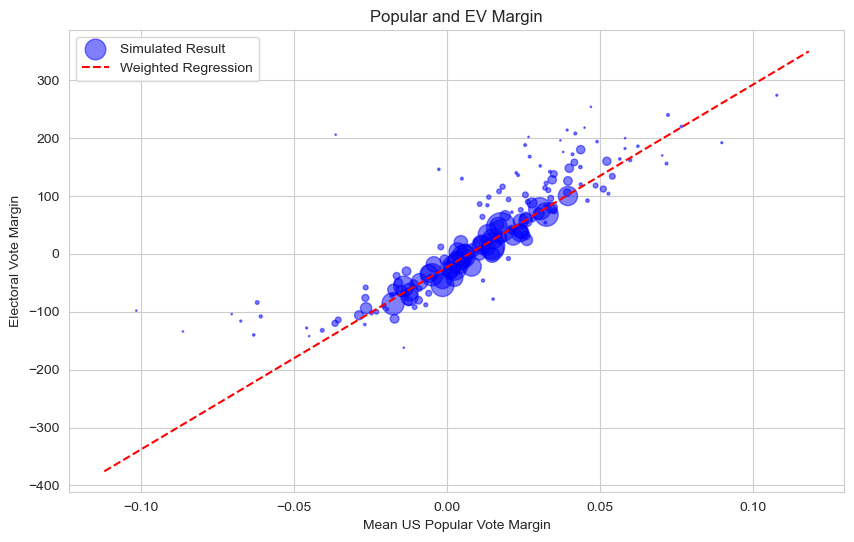

In [194]:
# Create scatter plot
plt.figure(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(margin_and_ec['pop'], margin_and_ec['ec'], 
            s=margin_and_ec['count'], color='blue', alpha=0.5, label='Simulated Result')

# Perform weighted linear regression using 'Count' as the weight
X = margin_and_ec['pop']
y = margin_and_ec['ec']
weights = margin_and_ec['count']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

# Add labels and title
plt.xlabel('Mean US Popular Vote Margin')
plt.ylabel('Electoral Vote Margin')
plt.title('Popular and EV Margin')

# Add legend
plt.legend()

# Show plot
plt.savefig('margin_needed.png')

In [195]:
print("Electoral College advantage: "+f"{100*-intercept/slope:.2f}"+"%")

Electoral College advantage: 0.72%


In [196]:
df_winp = df_results.filter(regex='_margin$')
df_winp.columns = df_winp.columns.str.replace('_margin$', '', regex=True)
df_winp = df_winp.map(lambda x: 0 if x < 0 else 1)

df_winp = df_winp.merge(df_ec[['dem_ec','dem', 'gop']], left_index=True, right_index=True, how='left')
df_winp['us_margin'] = df_dem.US-df_gop.US

In [197]:
df_margin = pd.DataFrame()
df_margin['hdi_03'] = (df_dem - df_gop).quantile(0.03)
df_margin['hdi_25'] = (df_dem - df_gop).quantile(0.25)
df_margin['hdi_mean'] = (df_dem - df_gop).quantile(0.50)
df_margin['hdi_75'] = (df_dem - df_gop).quantile(0.75)
df_margin['hdi_97'] = (df_dem - df_gop).quantile(0.97)
#f_margin = df_margin*1.15

df_margin = df_margin.merge(df_win_pct,left_index=True, right_index=True)
df_margin = pd.merge(df_margin,df_state[['state_code','electoral_2024']], left_index=True, right_on='state_code')

df_margin['scale'] = 10

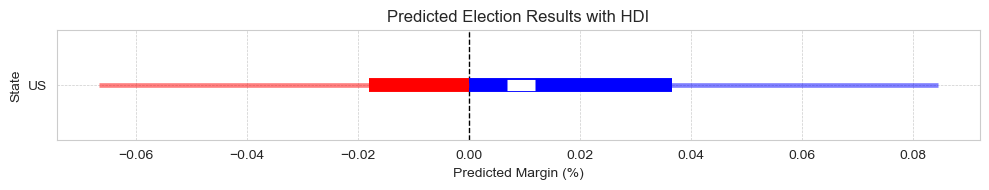

In [198]:
# Sort the dataframe by the absolute value of 'hdi_mean'
chart_df = df_margin.query("state_code == 'US'").sort_values(by='hdi_mean')
scale_factor = 1

# Create custom y-axis positions based on cumulative electoral votes
cumulative_votes = np.cumsum(chart_df['scale'] * scale_factor)
y_positions = cumulative_votes - (chart_df['scale'] * scale_factor / 2)

# Set up the figure
plt.figure(figsize=(10, 2))

# Plot each segment of the 50% HDI interval
for i, row in chart_df.iterrows():
    plt.hlines(y=y_positions[i], xmin=row['hdi_mean']-.0025, xmax=row['hdi_mean']+.0025, color='white', alpha=1, linewidth=row['scale'] * scale_factor*.8, zorder=5)
    #plt.hlines(y=y_positions[i], xmin=row['margin']-.0025, xmax=row['margin']+.0025, color='lime', alpha=1, linewidth=row['electoral_2024'] * scale_factor, zorder=5)
    # If hdi_75 is above 0, split the interval at 0
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['scale'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['scale'] * scale_factor, zorder=3)
    # If hdi_97 is above 0, split the interval at 0
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

# Set the y-axis labels to the state codes
plt.yticks(y_positions, chart_df['state_code'])

# Labels and title
plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Predicted Election Results with HDI')

# Improve grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()

# Display the plot
plt.savefig('us.png')

In [199]:
df_margin

,hdi_03,hdi_25,hdi_mean,hdi_75,hdi_97,dem,gop,state_code,electoral_2024,scale
4,0.197013,0.241101,0.264769,0.288312,0.330494,1.0000,0.0000,CA,54,10
9,-0.150138,-0.101623,-0.074904,-0.048351,-0.000014,0.0300,0.9700,FL,30,10
24,-0.062684,-0.015773,0.009021,0.034665,0.080339,0.6024,0.3976,MI,15,10
25,-0.011091,0.037155,0.064548,0.091297,0.135801,0.9444,0.0556,MN,10,10
38,0.080411,0.132367,0.161446,0.189741,0.237625,0.9998,0.0002,NY,28,10
44,-0.065704,-0.019937,0.004394,0.029540,0.073877,0.5473,0.4527,PA,19,10
52,-0.009867,0.037045,0.063636,0.089426,0.135707,0.9458,0.0542,VA,13,10
55,-0.061263,-0.014568,0.010464,0.035974,0.082967,0.6081,0.3919,WI,10,10
29,-0.066782,-0.018088,0.009454,0.036651,0.084589,0.5898,0.4102,US,0,10
2,-0.099347,-0.051681,-0.025096,0.002077,0.047526,0.2653,0.7347,AZ,11,10


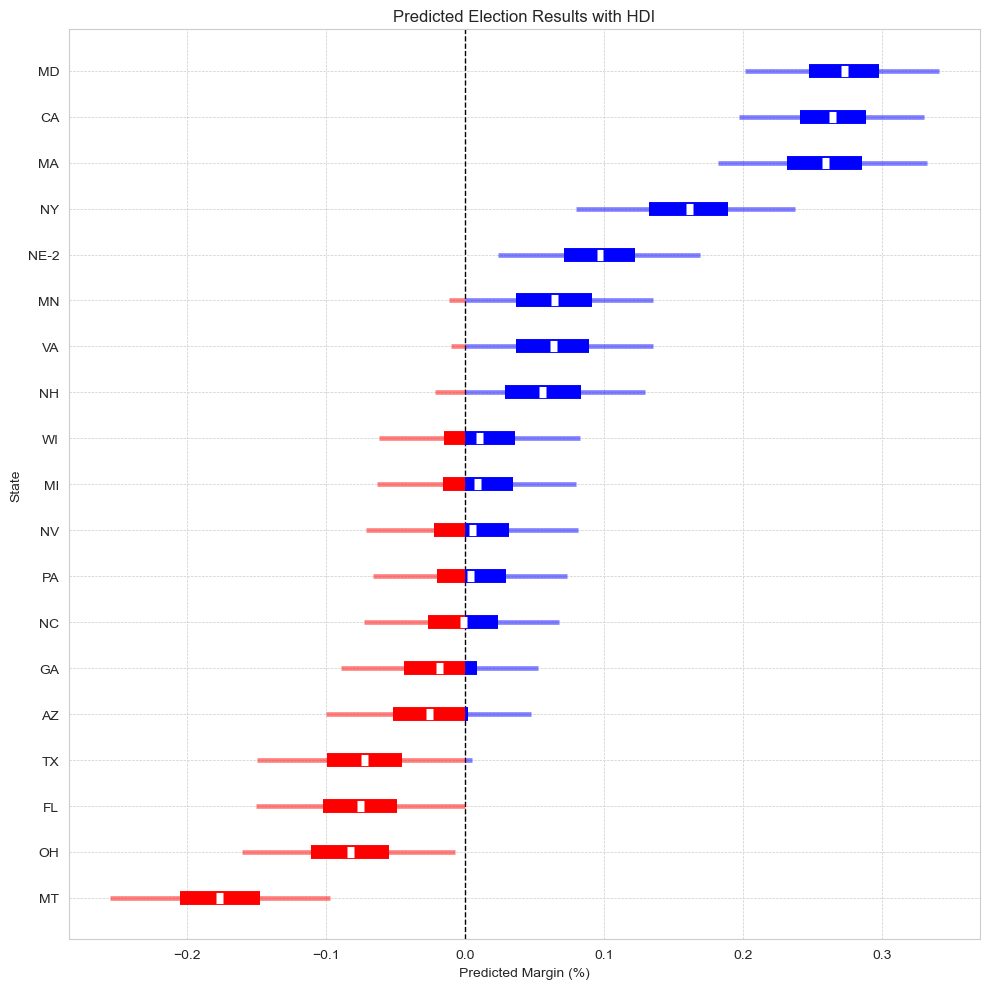

In [200]:
# Sort the dataframe by the absolute value of 'hdi_mean'
chart_df = df_margin.query("state_code != 'US'").sort_values(by='hdi_mean')
scale_factor = 1

# Create custom y-axis positions based on cumulative electoral votes
cumulative_votes = np.cumsum(chart_df['scale'] * scale_factor)
y_positions = cumulative_votes - (chart_df['scale'] * scale_factor / 2)

# Set up the figure
plt.figure(figsize=(10, 10))

# Plot each segment of the 50% HDI interval
for i, row in chart_df.iterrows():
    plt.hlines(y=y_positions[i], xmin=row['hdi_mean']-.0025, xmax=row['hdi_mean']+.0025, color='white', alpha=1, linewidth=row['scale'] * scale_factor*.8, zorder=5)
    #plt.hlines(y=y_positions[i], xmin=row['margin']-.0025, xmax=row['margin']+.0025, color='lime', alpha=1, linewidth=row['electoral_2024'] * scale_factor, zorder=5)
    # If hdi_75 is above 0, split the interval at 0
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['scale'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['scale'] * scale_factor, zorder=3)
    # If hdi_97 is above 0, split the interval at 0
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

# Set the y-axis labels to the state codes
plt.yticks(y_positions, chart_df['state_code'])

# Labels and title
plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Predicted Election Results with HDI')

# Improve grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()

# Display the plot
plt.savefig('all_states.png')

In [201]:
grouped_df = df_winp.groupby(list(df_winp.columns[1:-1])).agg(
    count=('us_margin', 'size'),   # Count the occurrences of each unique combination of rows
    margin_mean=('us_margin', 'mean')  # Calculate the mean of the 'margin' column
).reset_index().sort_values("count", ascending = False)
grouped_df.to_excel('df_value_counts.xlsx', index=False)

def conditional_probability(df, col_A, col_B):
    # Joint probability of A and B both being true (P(A ∩ B))
    P_A_and_B = ((df[col_A] == 1) & (df[col_B] == 1)).mean()
    
    # Probability of B being true (P(B))
    P_B = (df[col_B] == 1).mean()
    
    # Conditional probability P(A | B)
    return P_A_and_B / P_B if P_B != 0 else 0

# Create a table of conditional probabilities for each pair of columns
conditional_prob_table = pd.DataFrame(index=df_winp.iloc[:, :-2].columns, columns=df_winp.iloc[:, :-2].columns)

for col_A in df_winp.iloc[:, :-3].columns:
    for col_B in df_winp.iloc[:, :-2].columns:
        conditional_prob_table.loc[col_A, col_B] = conditional_probability(df_winp.iloc[:, :-2], col_A, col_B)

# Convert to float for easier viewing
conditional_prob_table = conditional_prob_table.astype(float)

selected_states = df_winp.loc[:, (df_winp.mean(axis=0) >= 0.03) & (df_winp.mean(axis=0) <= .97)].iloc[:,:-1].columns

conditional_prob_table.loc[selected_states, selected_states]

,FL,MI,MN,PA,VA,WI,US,AZ,GA,NC,NV,NH,TX
FL,1.000000,0.041667,0.031237,0.040745,0.031191,0.039467,0.041370,0.055032,0.049619,0.039730,0.041361,0.031789,0.104592
MI,0.836667,1.000000,0.611288,0.662342,0.609854,0.662884,0.672431,0.709009,0.686149,0.660864,0.679857,0.618637,0.785714
MN,0.983333,0.958333,1.000000,0.960168,0.947558,0.959053,0.968803,0.975876,0.969863,0.959451,0.964369,0.949640,0.984694
PA,0.743333,0.601760,0.556438,1.000000,0.555614,0.600559,0.611902,0.639653,0.615221,0.604546,0.615756,0.560411,0.750000
VA,0.983333,0.957503,0.948962,0.960168,1.000000,0.957079,0.960326,0.972107,0.966514,0.955765,0.964548,0.950295,0.974490
WI,0.800000,0.669157,0.617535,0.667276,0.615352,1.000000,0.671923,0.716547,0.690411,0.657997,0.677171,0.621258,0.780612
US,0.813333,0.658367,0.605040,0.659419,0.598858,0.651702,1.000000,0.712778,0.700457,0.655130,0.673590,0.607057,0.806122
AZ,0.486667,0.312251,0.274142,0.310068,0.272679,0.312613,0.320617,1.000000,0.339726,0.317018,0.314772,0.276273,0.482143
GA,0.543333,0.374170,0.337357,0.369267,0.335695,0.372965,0.390132,0.420656,1.000000,0.372312,0.400716,0.337667,0.512755
NC,0.646667,0.535691,0.496082,0.539375,0.493445,0.528367,0.542387,0.583490,0.553425,1.000000,0.558102,0.498908,0.676020


Percent of wins that require winning this state:

In [202]:
grouped_df_res = grouped_df.loc[
    grouped_df[["GA","OH"]].eq(1).all(axis=1) &
    grouped_df[["NC"]].eq(0).all(axis=1)
]

winnings odds D

In [203]:
(grouped_df_res["count"]*grouped_df_res["dem_ec"]).sum()/grouped_df_res["count"].sum()

0.90625

Margin

In [204]:
(grouped_df_res["count"]*grouped_df_res.margin_mean).sum()/grouped_df_res["count"].sum()

0.032396590980235396

In [205]:
swing_state_df = pd.DataFrame()
swing_state_df['dem'] = df_winp.query("dem_ec == 1").mean()[states]
swing_state_df['gop'] = 1-df_winp.query("gop > 269").mean()[states]
swing_state_df['score'] = (swing_state_df['dem'] * swing_state_df['gop'])**.5

swing_state_df.sort_values('score', ascending=False).head(10)

,dem,gop,score
PA,0.790648,0.713469,0.751068
MI,0.816048,0.629183,0.716549
NC,0.681547,0.726811,0.703815
WI,0.787955,0.592334,0.683178
NV,0.714451,0.617535,0.664228
GA,0.499327,0.862558,0.656276
US,0.712526,0.545320,0.623342
AZ,0.400423,0.889242,0.596719
NH,0.961516,0.132571,0.357028
MN,0.983644,0.098687,0.311565


In [206]:
df_winp['ec_margin'] = df_winp['dem'] - df_winp['gop']

In [207]:
grouped_df

,FL,MI,MN,NY,PA,VA,WI,US,AZ,GA,...,MD,NE-2,TX,MT,OH,dem_ec,dem,gop,count,margin_mean
1117,0,1,1,1,1,1,1,1,0,1,...,1,1,0,0,0,1,308,230,196,0.042368
1098,0,1,1,1,1,1,1,1,0,0,...,1,1,0,0,0,1,292,246,186,0.035120
178,0,0,1,1,0,1,0,0,0,0,...,1,1,0,0,0,0,226,312,164,-0.037632
1152,0,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,1,319,219,159,0.049629
1090,0,1,1,1,1,1,1,1,0,0,...,1,1,0,0,0,1,276,262,156,0.038274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,0,1,1,1,0,1,1,1,1,0,...,1,1,0,0,0,0,264,274,1,0.005753
867,0,1,1,1,0,1,1,1,1,0,...,1,0,0,0,0,0,267,271,1,0.000694
372,0,0,1,1,1,0,1,1,0,0,...,1,1,0,0,0,0,264,274,1,0.020001
368,0,0,1,1,1,0,1,0,1,1,...,1,1,0,0,0,0,269,269,1,-0.006497
